In [1]:
# !pip install pycocotools --quiet
# !git clone https://github.com/pytorch/vision.git
# !git checkout v0.3.0

# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

In [2]:
import os
import numpy as np
import torch as tc
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm, trange
import pickle

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
# import transforms as T
#import cv2
from WishDataSet import WishTubeFrameDataSet, get_transform
from wish_utils import *

In [3]:
tc.__version__

'2.2.1+cu118'

In [4]:
tc.cuda.is_available(), tc.cuda.device_count()

(True, 1)

In [5]:
!nvidia-smi

Mon Apr 29 22:34:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76                 Driver Version: 550.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:04:00.0 Off |                  N/A |
| 43%   56C    P8             12W /  125W |     256MiB /   8192MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
tc.cuda.current_device(), tc.cuda.device(0), tc.cuda.get_device_name()

(0, <torch.cuda.device at 0x7f15bfcf7520>, 'Quadro RTX 4000')

In [7]:
annotations_dir = "/home/wj1132075/Desktop/CNN_Model_Data/TByTWithNeighIncreasedRange02/Annotations/"
ds = WishTubeFrameDataSet(annotations_dir)
len(ds)

16401

In [8]:
im, tar = ds[53]
type(im), type(tar)
tar

{'boxes': tensor([[608.,  65., 630.,  75.],
         [235.,  52., 248.,  62.],
         [237.,  65., 249.,  75.],
         [233.,  78., 246.,  88.]]),
 'labels': tensor([1, 1, 1, 1]),
 'area': tensor([220., 130., 120., 130.]),
 'iscrowd': tensor([0, 0, 0, 0]),
 'image_id': 53}

In [9]:
im.shape

(128, 1540, 3)

In [10]:
tar

{'boxes': tensor([[608.,  65., 630.,  75.],
         [235.,  52., 248.,  62.],
         [237.,  65., 249.,  75.],
         [233.,  78., 246.,  88.]]),
 'labels': tensor([1, 1, 1, 1]),
 'area': tensor([220., 130., 120., 130.]),
 'iscrowd': tensor([0, 0, 0, 0]),
 'image_id': 53}

In [11]:
im[..., 0].shape

(128, 1540)

In [12]:
def plot_tube_frame_with_bbox(image, target):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cs = plt.contourf(image[..., 0])
    plt.colorbar(cs)    
    for xmin, ymin, xmax, ymax in target['boxes']:
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin),
                                 width, height,
                                 linewidth = 0.4,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        ax.add_patch(rect)
    plt.show()

### See tube frames and boxes

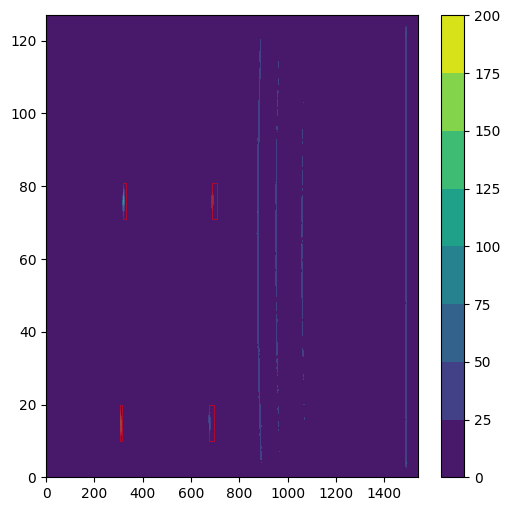

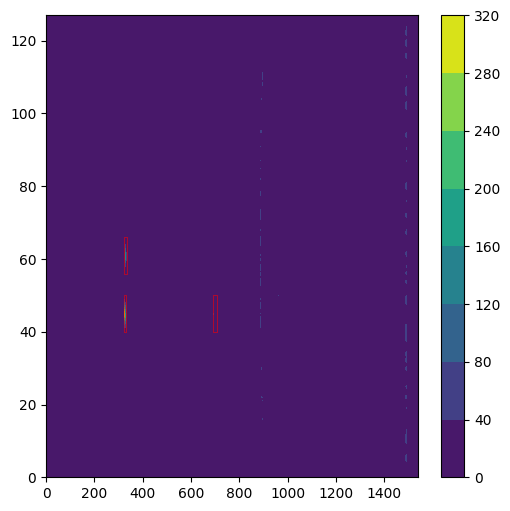

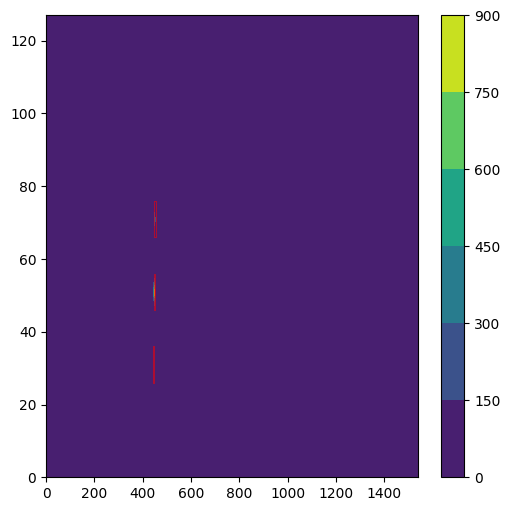

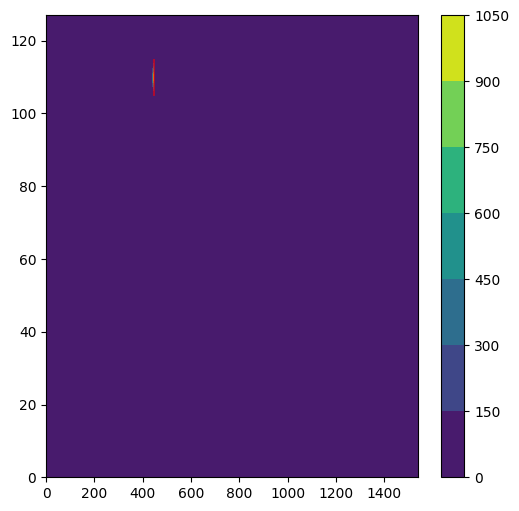

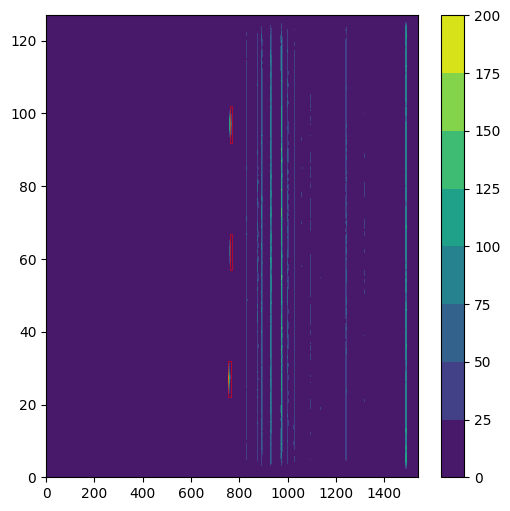

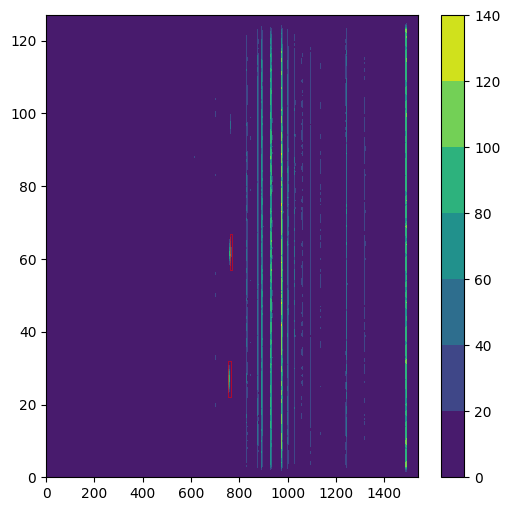

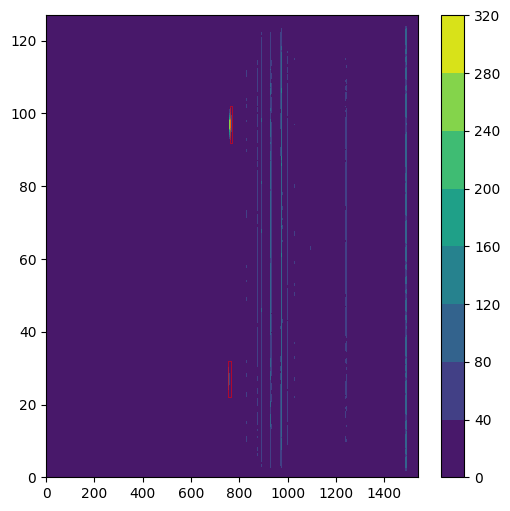

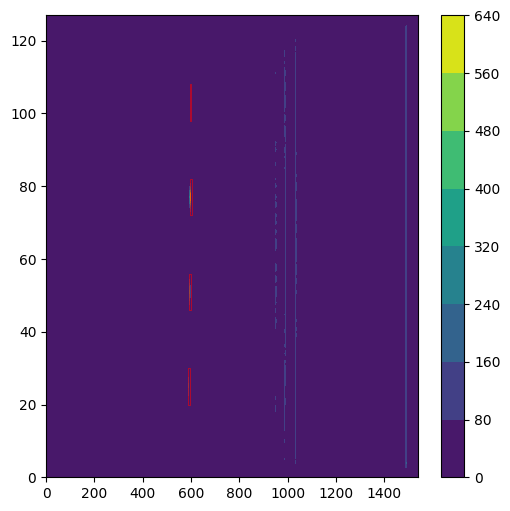

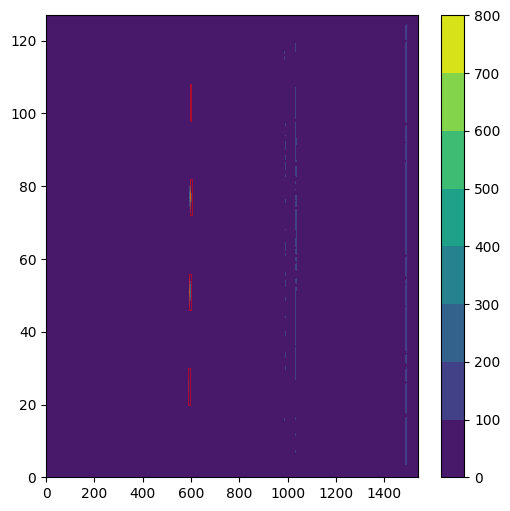

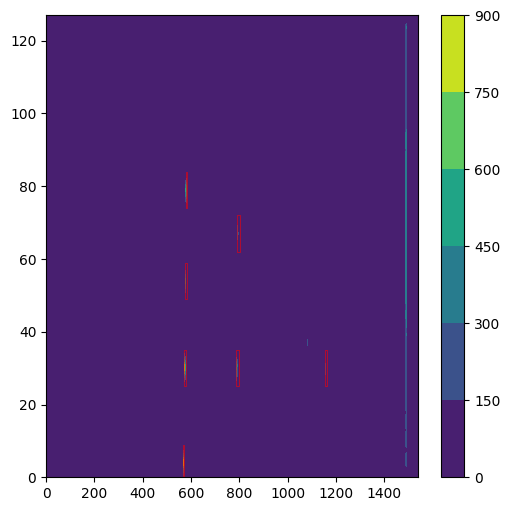

In [13]:
i=0
for (im, tar) in ds:
    plot_tube_frame_with_bbox(im, tar)
    i+=1
    if i == 10:
        break

### Calculate the stats

In [14]:
# dl = tc.utils.data.DataLoader(ds, batch_size=100, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)
# stats = get_stats(dl)
# stats

In [15]:
# stats = (np.array([1.26653515, 1.26653515, 1.26653515]), np.array([4.59509826, 4.59509826, 4.59509826]))
# stats

### Training and test data sets

In [16]:
# use our dataset and defined transformations
stats=None
dataset = WishTubeFrameDataSet(annotations_dir, transforms=get_transform(train=True))
dataset_test = WishTubeFrameDataSet(annotations_dir, transforms=get_transform(train=False))

In [17]:
# split the dataset in train and test set
tc.manual_seed(1)
indices = tc.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = tc.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = tc.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = tc.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_test = tc.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

### Model Training

In [18]:
# to train on gpu if selected.
device = tc.device('cuda') if tc.cuda.is_available() else tc.device('cpu')

num_classes = 2

model = get_object_detection_model(num_classes, pretrained=False)
freeze_to(model, False)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
p=[p.requires_grad for p in model.parameters()]
len(p)

83

In [20]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [21]:
device

device(type='cuda')

In [22]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = tc.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = tc.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=3,
                                            gamma=0.1)# to train on gpu if selected.

In [23]:
params[-5:]

[Parameter containing:
 tensor([ 0.0276,  0.0089,  0.0034,  ...,  0.0247,  0.0203, -0.0271],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0233,  0.0245, -0.0254,  ..., -0.0010,  0.0027,  0.0029],
         [-0.0099, -0.0231,  0.0079,  ...,  0.0121, -0.0268, -0.0056]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0080,  0.0260], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0024,  0.0246, -0.0064,  ..., -0.0062, -0.0271, -0.0296],
         [ 0.0120, -0.0312, -0.0247,  ..., -0.0158, -0.0009,  0.0020],
         [ 0.0125, -0.0144, -0.0234,  ...,  0.0149, -0.0270, -0.0274],
         ...,
         [ 0.0036,  0.0001,  0.0144,  ..., -0.0071, -0.0091, -0.0148],
         [-0.0059, -0.0292, -0.0288,  ..., -0.0212, -0.0215,  0.0083],
         [ 0.0249, -0.0257, -0.0149,  ..., -0.0293,  0.0304,  0.0100]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0150,  0.0234, 

In [24]:
len(params)

72

In [25]:
lr_scheduler

### Training 

In [26]:
num_epochs = 15 #NOTE!! This can be reduced to 15 Epochs for larger dataset

for epoch in trange(num_epochs):
    # training for one epoch
    print(f"starting epoch {epoch}")
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

starting epoch 0
Epoch: [0]  [   0/1641]  eta: 0:36:08  lr: 0.000010  loss: 14.8897 (14.8897)  loss_classifier: 0.8623 (0.8623)  loss_box_reg: 0.3957 (0.3957)  loss_objectness: 5.0116 (5.0116)  loss_rpn_box_reg: 8.6201 (8.6201)  time: 1.3216  data: 0.2603  max mem: 2126
Epoch: [0]  [ 100/1641]  eta: 0:11:04  lr: 0.000509  loss: 0.9930 (2.2402)  loss_classifier: 0.0450 (0.1129)  loss_box_reg: 0.1089 (0.1158)  loss_objectness: 0.3046 (0.5904)  loss_rpn_box_reg: 0.5082 (1.4212)  time: 0.4275  data: 0.0189  max mem: 2325
Epoch: [0]  [ 200/1641]  eta: 0:10:18  lr: 0.001009  loss: 0.6164 (1.4898)  loss_classifier: 0.0168 (0.0680)  loss_box_reg: 0.0395 (0.0933)  loss_objectness: 0.0952 (0.3683)  loss_rpn_box_reg: 0.4640 (0.9603)  time: 0.4177  data: 0.0204  max mem: 2325
Epoch: [0]  [ 300/1641]  eta: 0:09:33  lr: 0.001508  loss: 0.3804 (1.1648)  loss_classifier: 0.0199 (0.0520)  loss_box_reg: 0.0485 (0.0763)  loss_objectness: 0.0432 (0.2692)  loss_rpn_box_reg: 0.2493 (0.7673)  time: 0.4221  d

#### Save the trained model

In [27]:
model_save_path = '/mnt/ceph/home/wj1132075/Desktop/CNN_Model_Data/TbyT_rot_ax0ax1_withneighb_fasterrcnn_resnet50_fpn.pt'

In [28]:
tc.save(model.state_dict(), model_save_path)

In [29]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with tc.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  12
real #boxes:  7


In [30]:
prediction

{'boxes': tensor([[5.7548e+02, 7.0967e+01, 5.8642e+02, 8.0954e+01],
         [3.5923e+02, 6.3062e+01, 3.6498e+02, 7.3058e+01],
         [3.4238e+02, 4.5408e-02, 3.4821e+02, 6.8495e+00],
         [5.5714e+02, 9.5961e-03, 5.6807e+02, 7.1631e+00],
         [5.6554e+02, 2.1062e+01, 5.7621e+02, 3.0916e+01],
         [3.5242e+02, 3.0106e+01, 3.5846e+02, 4.0191e+01],
         [3.5538e+02, 4.7187e+01, 3.6137e+02, 5.7213e+01],
         [9.3774e+02, 4.6625e+01, 9.5052e+02, 5.6536e+01],
         [3.6016e+02, 8.0035e+01, 3.6601e+02, 9.0056e+01],
         [3.4802e+02, 1.3473e+01, 3.5372e+02, 2.2546e+01],
         [9.2231e+02, 8.4530e-01, 9.3621e+02, 9.9813e+00],
         [3.5748e+02, 4.7151e+01, 3.6353e+02, 5.7211e+01]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9990, 0.9981, 0.9947, 0.9560, 0.7895, 0.7817, 0.7731, 0.7381, 0.6317,
         0.5703, 0.5004, 0.1144], device='cuda:0')}

In [31]:
target

{'boxes': tensor([[359.,  62., 365.,  72.],
         [341.,   0., 347.,   6.],
         [349.,  12., 354.,  22.],
         [556.,   0., 567.,   6.],
         [567.,  20., 578.,  30.],
         [574.,  70., 585.,  80.],
         [923.,   0., 936.,   6.]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
 'area': tensor([ 60.,  36.,  50.,  66., 110., 110.,  78.]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]),
 'image_id': 7023}

In [32]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[5.7548e+02, 7.0967e+01, 5.8642e+02, 8.0954e+01],
         [3.5923e+02, 6.3062e+01, 3.6498e+02, 7.3058e+01],
         [3.4238e+02, 4.5408e-02, 3.4821e+02, 6.8495e+00],
         [5.5714e+02, 9.5961e-03, 5.6807e+02, 7.1631e+00],
         [5.6554e+02, 2.1062e+01, 5.7621e+02, 3.0916e+01],
         [3.5242e+02, 3.0106e+01, 3.5846e+02, 4.0191e+01],
         [3.5538e+02, 4.7187e+01, 3.6137e+02, 5.7213e+01],
         [9.3774e+02, 4.6625e+01, 9.5052e+02, 5.6536e+01],
         [3.6016e+02, 8.0035e+01, 3.6601e+02, 9.0056e+01],
         [3.4802e+02, 1.3473e+01, 3.5372e+02, 2.2546e+01],
         [9.2231e+02, 8.4530e-01, 9.3621e+02, 9.9813e+00]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9990, 0.9981, 0.9947, 0.9560, 0.7895, 0.7817, 0.7731, 0.7381, 0.6317,
         0.5703, 0.5004], device='cuda:0')}

In [33]:
img.shape

torch.Size([3, 128, 1540])

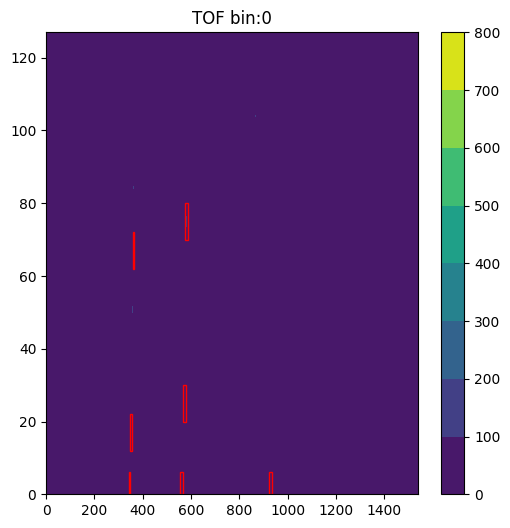

In [34]:
plot_bin(img[0,:,:], target['boxes'], 0)

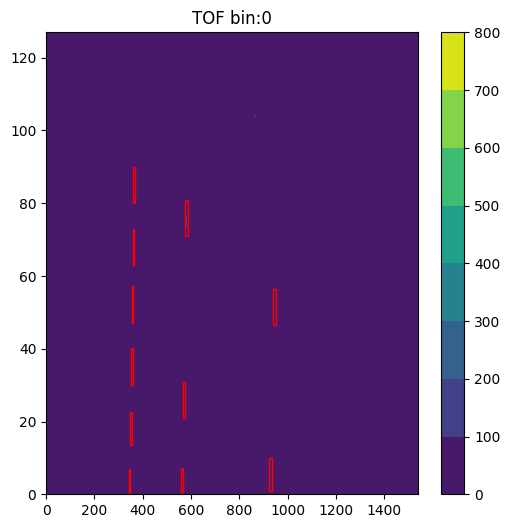

In [35]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

### Load the model from disk

In [36]:
r_model = get_object_detection_model(num_classes)
# r_model.load_state_dict(tc.load(model_save_path))
r_model.load_state_dict(tc.load(model_save_path, map_location=tc.device('cpu')))
r_model = r_model.to(device)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
img, target = dataset_test[100]
r_model.eval()
with tc.no_grad():
    prediction = r_model([img.to(device)])[0]
prediction

{'boxes': tensor([[419.9427, 102.9565, 450.6603, 113.0199]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9989], device='cuda:0')}

In [38]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[419.9427, 102.9565, 450.6603, 113.0199]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9989], device='cuda:0')}

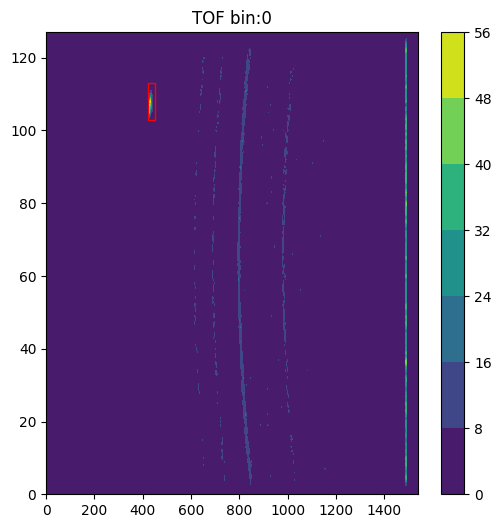

In [39]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

In [40]:
def plot_frame_detections(bin_data, real_boxes, predicted_boxes, score_threshold = 0.75):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cs = plt.contourf(bin_data)
    plt.colorbar(cs)
    for box in real_boxes.cpu():
        det_x, det_y = (box[0]+box[2])/2, (box[1]+box[3])/2
        plt.plot(det_x, det_y, marker="x", markersize=9, markeredgecolor="lime", markerfacecolor="lime")
        
    plotted_predictions = 0
    for box, score in zip(predicted_boxes['boxes'].cpu(), predicted_boxes['scores'].cpu()):
        print(f"prediction={box} score={score}")
        x_hat, y_hat = (box[0]+box[2])/2, (box[1]+box[3])/2
        if score < score_threshold:
            print(f"----->Ignoring the prediction at x={x_hat} y={y_hat} with score={score}")
            plt.plot(x_hat, y_hat, marker="x", markersize=5, markeredgecolor="white", markerfacecolor="white")
            continue
            
        print(f"Prediction coordinate x={x_hat} y={y_hat}")
        plt.plot(x_hat, y_hat, marker="x", markersize=5, markeredgecolor="red", markerfacecolor="red")
        plotted_predictions += 1

    plt.title(f"Predicted-{plotted_predictions} vs Real-{len(real_boxes)}")
    plt.show()

{'boxes': tensor([[613.9606,  55.0259, 621.9048,  64.9916],
        [614.2325,  82.0193, 622.0405,  92.0352],
        [611.0983,  27.7682, 618.4520,  37.8296],
        [605.8701,   1.1032, 613.3772,  10.9529]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.8039, 0.8037, 0.7699], device='cuda:0')}
prediction=tensor([613.9606,  55.0259, 621.9048,  64.9916]) score=0.9994658827781677
Prediction coordinate x=617.9327392578125 y=60.008750915527344
prediction=tensor([614.2325,  82.0193, 622.0405,  92.0352]) score=0.8039089441299438
Prediction coordinate x=618.136474609375 y=87.0272216796875
prediction=tensor([611.0983,  27.7682, 618.4520,  37.8296]) score=0.8036519289016724
Prediction coordinate x=614.775146484375 y=32.79890441894531
prediction=tensor([605.8701,   1.1032, 613.3772,  10.9529]) score=0.7699064612388611
Prediction coordinate x=609.6236572265625 y=6.028038024902344


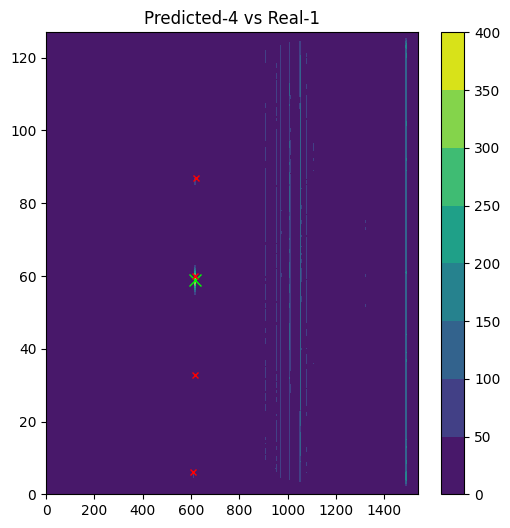

{'boxes': tensor([[247.6928, 109.1829, 251.8659, 119.0470]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}
prediction=tensor([247.6928, 109.1829, 251.8659, 119.0470]) score=0.9943033456802368
Prediction coordinate x=249.77938842773438 y=114.11491394042969


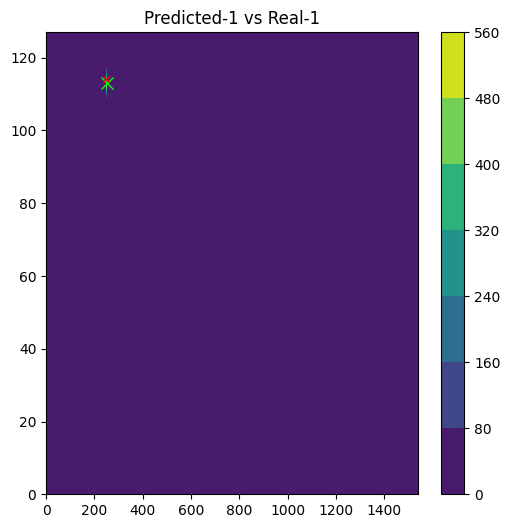

{'boxes': tensor([[462.7446,  99.9411, 469.6353, 109.9707]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9849], device='cuda:0')}
prediction=tensor([462.7446,  99.9411, 469.6353, 109.9707]) score=0.9849377870559692
Prediction coordinate x=466.1899108886719 y=104.95588684082031


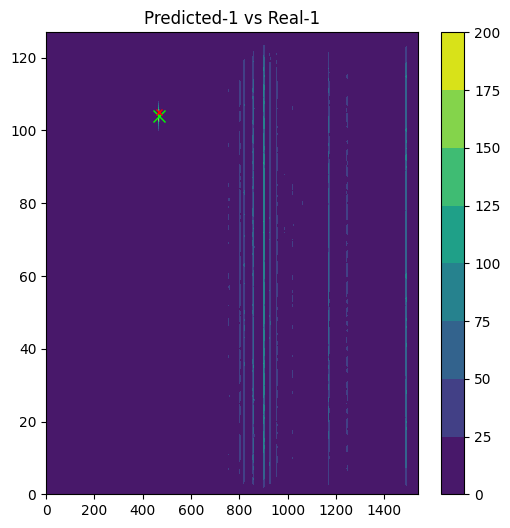

{'boxes': tensor([[533.6063,  92.0085, 541.5031, 101.9931]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}
prediction=tensor([533.6063,  92.0085, 541.5031, 101.9931]) score=0.9984366297721863
Prediction coordinate x=537.5546875 y=97.00079345703125


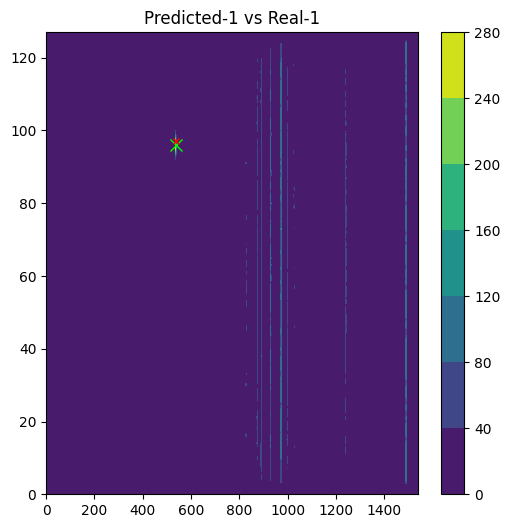

{'boxes': tensor([[442.8220,   2.8902, 449.9206,  12.9269]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}
prediction=tensor([442.8220,   2.8902, 449.9206,  12.9269]) score=0.9992497563362122
Prediction coordinate x=446.3713073730469 y=7.908559799194336


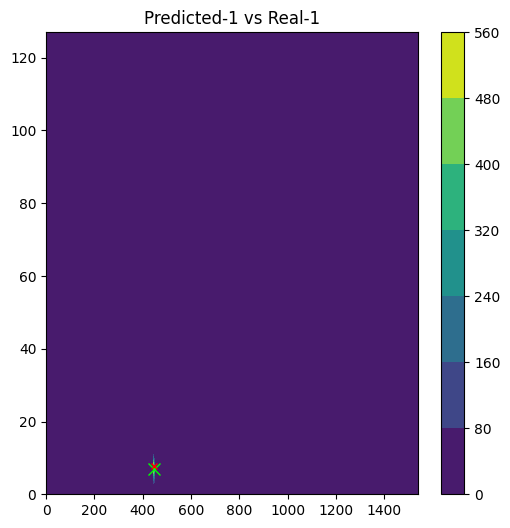

{'boxes': tensor([[5.7547e+02, 7.0966e+01, 5.8640e+02, 8.0954e+01],
        [3.5922e+02, 6.3063e+01, 3.6497e+02, 7.3057e+01],
        [3.4238e+02, 4.5907e-02, 3.4823e+02, 6.8498e+00],
        [5.5713e+02, 6.1651e-03, 5.6808e+02, 7.1624e+00],
        [5.6552e+02, 2.1055e+01, 5.7622e+02, 3.0920e+01],
        [3.5241e+02, 3.0106e+01, 3.5846e+02, 4.0187e+01],
        [3.5538e+02, 4.7187e+01, 3.6138e+02, 5.7211e+01],
        [9.3774e+02, 4.6630e+01, 9.5049e+02, 5.6538e+01],
        [3.6016e+02, 8.0033e+01, 3.6603e+02, 9.0057e+01],
        [3.4761e+02, 1.3553e+01, 3.5361e+02, 2.2361e+01],
        [9.2343e+02, 5.3522e-01, 9.3657e+02, 9.3083e+00]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.9982, 0.9949, 0.9560, 0.7878, 0.7804, 0.7684, 0.7381, 0.6281,
        0.5793, 0.5123], device='cuda:0')}
prediction=tensor([575.4663,  70.9664, 586.4013,  80.9539]) score=0.9989016056060791
Prediction coordinate x=580.933837890625 y=75

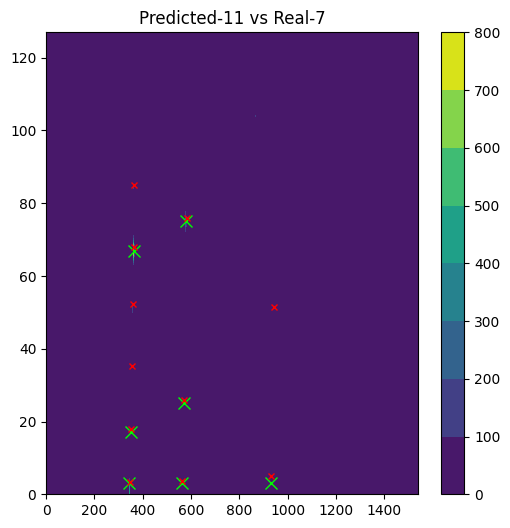

{'boxes': tensor([[238.0201,   9.8312, 252.8146,  19.9261]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}
prediction=tensor([238.0201,   9.8312, 252.8146,  19.9261]) score=0.9995197057723999
Prediction coordinate x=245.4173583984375 y=14.878649711608887


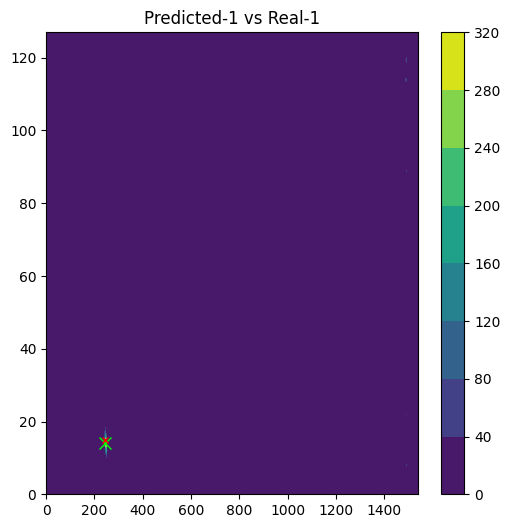

{'boxes': tensor([[5.0216e+02, 1.2039e-02, 5.0916e+02, 6.9817e+00],
        [5.0510e+02, 6.4124e+01, 5.1159e+02, 7.4064e+01],
        [5.0157e+02, 8.6301e+01, 5.0819e+02, 9.6293e+01],
        [5.0461e+02, 1.9100e+01, 5.1111e+02, 2.8603e+01],
        [5.0547e+02, 4.1987e+01, 5.1191e+02, 5.2099e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.9008, 0.8530, 0.8057, 0.7709], device='cuda:0')}
prediction=tensor([5.0216e+02, 1.2039e-02, 5.0916e+02, 6.9817e+00]) score=0.9966042041778564
Prediction coordinate x=505.65679931640625 y=3.496882915496826
prediction=tensor([505.1046,  64.1242, 511.5938,  74.0640]) score=0.9008133411407471
Prediction coordinate x=508.3492431640625 y=69.09408569335938
prediction=tensor([501.5731,  86.3008, 508.1935,  96.2926]) score=0.8530167937278748
Prediction coordinate x=504.88330078125 y=91.29672241210938
prediction=tensor([504.6089,  19.0998, 511.1144,  28.6033]) score=0.805657684803009
Prediction coordinat

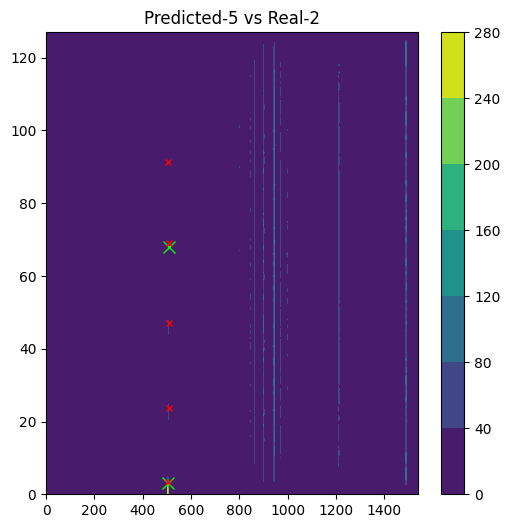

{'boxes': tensor([[282.5707,  43.0427, 294.4183,  53.0863],
        [642.8582, 114.9736, 663.3840, 124.8465],
        [275.6642, 115.0236, 285.9379, 124.9491]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9947, 0.9922, 0.9903], device='cuda:0')}
prediction=tensor([282.5707,  43.0427, 294.4183,  53.0863]) score=0.9947190284729004
Prediction coordinate x=288.4945068359375 y=48.06449890136719
prediction=tensor([642.8582, 114.9736, 663.3840, 124.8465]) score=0.9922397136688232
Prediction coordinate x=653.12109375 y=119.91007995605469
prediction=tensor([275.6642, 115.0236, 285.9379, 124.9491]) score=0.9902702569961548
Prediction coordinate x=280.80108642578125 y=119.98637390136719


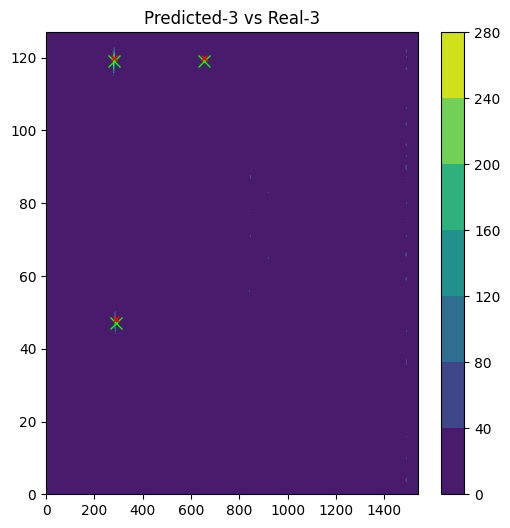

{'boxes': tensor([[506.5075,   5.9799, 513.1917,  16.0688],
        [489.5593,  92.9318, 495.6547, 102.9485],
        [481.4030, 113.9152, 487.2798, 123.8493]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.9948, 0.7277], device='cuda:0')}
prediction=tensor([506.5075,   5.9799, 513.1917,  16.0688]) score=0.9990617632865906
Prediction coordinate x=509.84954833984375 y=11.024349212646484
prediction=tensor([489.5593,  92.9318, 495.6547, 102.9485]) score=0.9947726130485535
Prediction coordinate x=492.6069641113281 y=97.94012451171875
prediction=tensor([481.4030, 113.9152, 487.2798, 123.8493]) score=0.7277445197105408
Prediction coordinate x=484.3414001464844 y=118.88229370117188


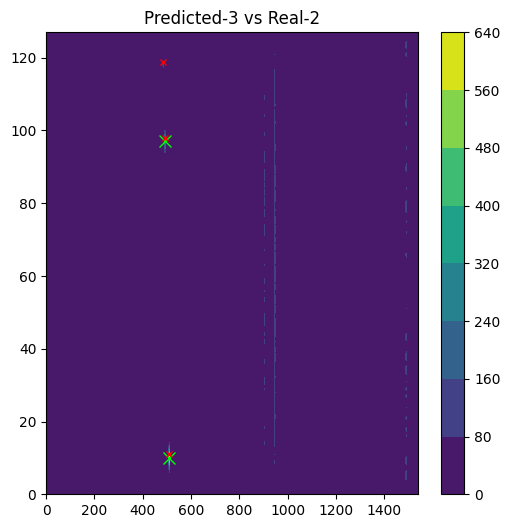

{'boxes': tensor([[615.2704,  99.9781, 625.3585, 109.9956],
        [610.8437,  17.8708, 621.0902,  27.8794],
        [399.0419,  35.9604, 405.1326,  45.9659],
        [395.9894,  17.9815, 401.7655,  28.0649],
        [614.3970,  45.9336, 624.5520,  55.9321],
        [398.9210, 108.8471, 404.6344, 118.8124],
        [401.4206,  90.9818, 407.0370, 100.9259],
        [984.1608,  73.8504, 995.3020,  83.7005],
        [400.6732,  54.9127, 406.2354,  64.8820],
        [401.3432,  72.6597, 407.0475,  82.6359],
        [979.0039,  17.7682, 990.9933,  27.6481],
        [984.3334,  57.1352, 996.0753,  67.2303]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.9992, 0.9832, 0.9620, 0.9273, 0.9131, 0.8580, 0.8119, 0.6908,
        0.6389, 0.3935, 0.0717], device='cuda:0')}
prediction=tensor([615.2704,  99.9781, 625.3585, 109.9956]) score=0.9993575215339661
Prediction coordinate x=620.314453125 y=104.98689270019531
prediction=te

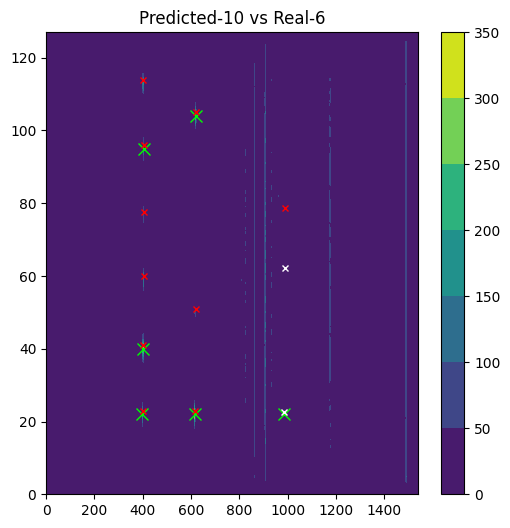

{'boxes': tensor([[625.8605,  43.9713, 633.4212,  53.9624]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}
prediction=tensor([625.8605,  43.9713, 633.4212,  53.9624]) score=0.9991829991340637
Prediction coordinate x=629.640869140625 y=48.966819763183594


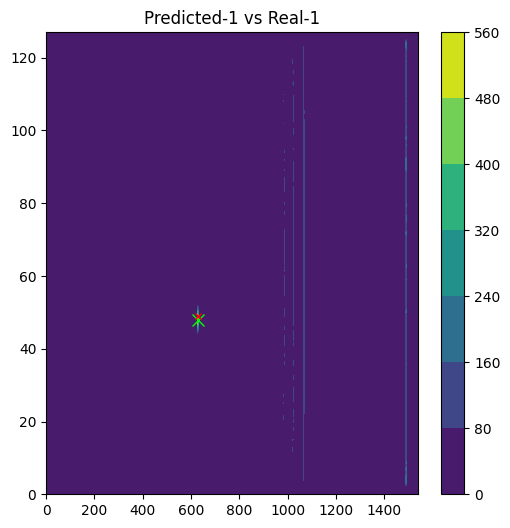

{'boxes': tensor([[599.3885, 103.1138, 609.9680, 113.0963],
        [389.7068,  84.9819, 395.1655,  94.9822],
        [395.8395,  68.0197, 400.9539,  77.9827],
        [967.5074, 102.8009, 979.0823, 112.9998],
        [607.7953,  76.9214, 618.0334,  86.9548],
        [384.4981, 103.1398, 389.6888, 113.0722],
        [397.8993,  49.7882, 403.0489,  59.9174]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.9966, 0.9759, 0.9030, 0.8577, 0.8399, 0.1946],
       device='cuda:0')}
prediction=tensor([599.3885, 103.1138, 609.9680, 113.0963]) score=0.997093677520752
Prediction coordinate x=604.67822265625 y=108.10505676269531
prediction=tensor([389.7068,  84.9819, 395.1655,  94.9822]) score=0.9965728521347046
Prediction coordinate x=392.4361572265625 y=89.9820556640625
prediction=tensor([395.8395,  68.0197, 400.9539,  77.9827]) score=0.975918710231781
Prediction coordinate x=398.396728515625 y=73.00119018554688
prediction=tensor([967.5074

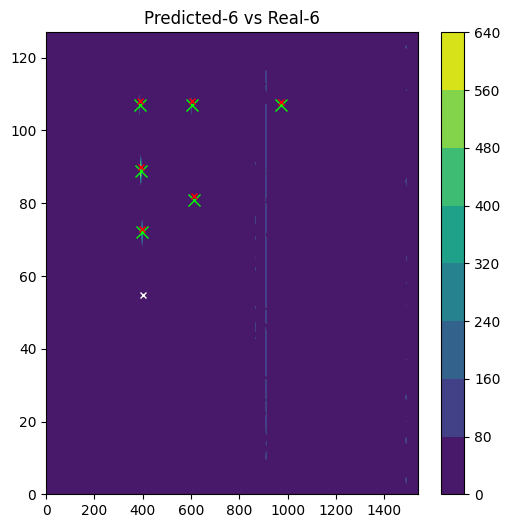

{'boxes': tensor([[685.1334,   7.1291, 696.7137,  17.1536],
        [692.6138,  37.8820, 704.0288,  47.9333]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.9112], device='cuda:0')}
prediction=tensor([685.1334,   7.1291, 696.7137,  17.1536]) score=0.9961650371551514
Prediction coordinate x=690.923583984375 y=12.141380310058594
prediction=tensor([692.6138,  37.8820, 704.0288,  47.9333]) score=0.9111892580986023
Prediction coordinate x=698.3212890625 y=42.907630920410156


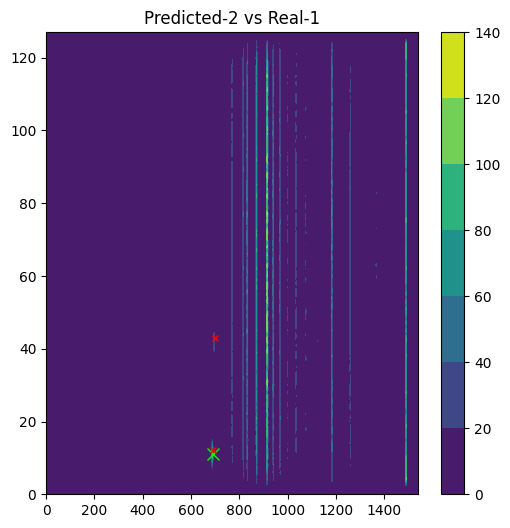

{'boxes': tensor([[185.2547,  53.9675, 192.0727,  63.9097],
        [185.5464,  64.8744, 192.0858,  74.9530],
        [183.5386,  41.1310, 189.8762,  51.1433]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9362, 0.9143, 0.8954], device='cuda:0')}
prediction=tensor([185.2547,  53.9675, 192.0727,  63.9097]) score=0.9361894130706787
Prediction coordinate x=188.6636962890625 y=58.93861770629883
prediction=tensor([185.5464,  64.8744, 192.0858,  74.9530]) score=0.9143182039260864
Prediction coordinate x=188.8160858154297 y=69.91368103027344
prediction=tensor([183.5386,  41.1310, 189.8762,  51.1433]) score=0.8954356908798218
Prediction coordinate x=186.7073974609375 y=46.13716506958008


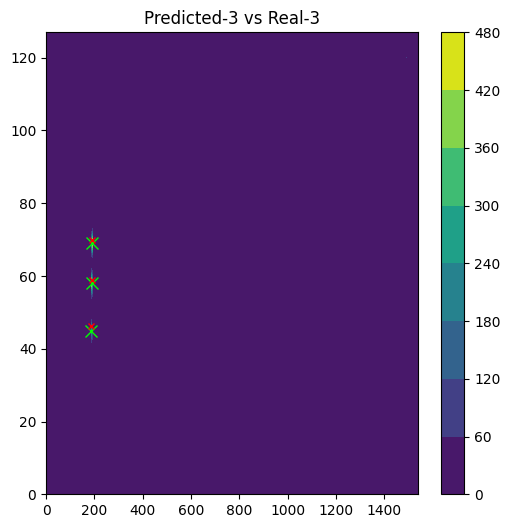

{'boxes': tensor([[629.5089, 120.0695, 637.3184, 127.8177]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}
prediction=tensor([629.5089, 120.0695, 637.3184, 127.8177]) score=0.9999220371246338
Prediction coordinate x=633.4136962890625 y=123.943603515625


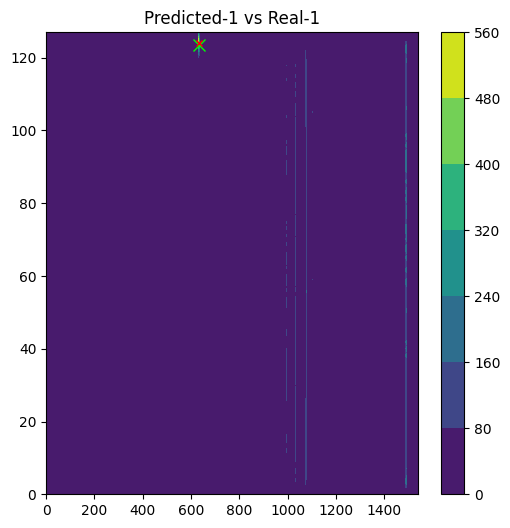

{'boxes': tensor([[436.2559, 122.0596, 443.0068, 128.0000],
        [446.0701,  62.8393, 453.3696,  72.7525],
        [440.6765, 103.0170, 447.8879, 112.9318],
        [444.2848,  82.8764, 451.6467,  92.6677]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.9034, 0.8724, 0.7905], device='cuda:0')}
prediction=tensor([436.2559, 122.0596, 443.0068, 128.0000]) score=0.9991801381111145
Prediction coordinate x=439.63134765625 y=125.02981567382812
prediction=tensor([446.0701,  62.8393, 453.3696,  72.7525]) score=0.9033581018447876
Prediction coordinate x=449.7198486328125 y=67.7958984375
prediction=tensor([440.6765, 103.0170, 447.8879, 112.9318]) score=0.8723534941673279
Prediction coordinate x=444.2822265625 y=107.97438049316406
prediction=tensor([444.2848,  82.8764, 451.6467,  92.6677]) score=0.7905035018920898
Prediction coordinate x=447.96575927734375 y=87.77207946777344


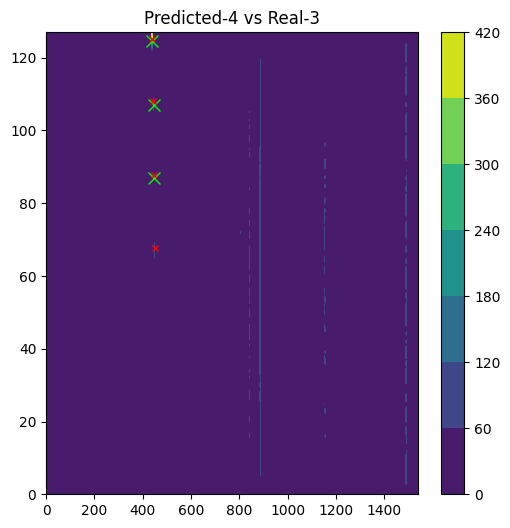

{'boxes': tensor([[3.3456e+02, 8.3463e-02, 3.4008e+02, 9.9548e+00]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}
prediction=tensor([3.3456e+02, 8.3463e-02, 3.4008e+02, 9.9548e+00]) score=0.9991644620895386
Prediction coordinate x=337.3211975097656 y=5.019128799438477


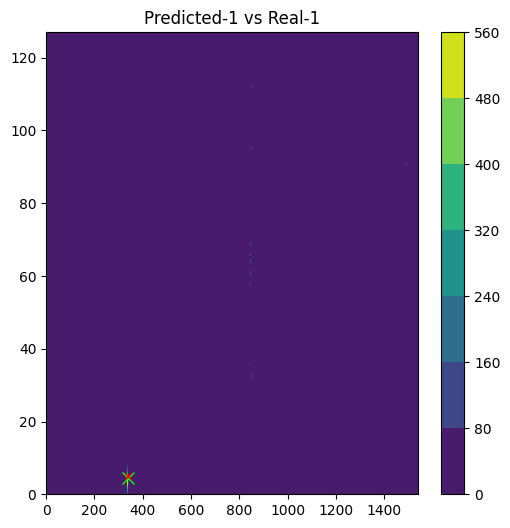

{'boxes': tensor([[215.8062,  27.0223, 231.4923,  36.9991],
        [212.0769,  65.9160, 227.7152,  75.9934],
        [215.8837,  40.0347, 232.8999,  50.0882],
        [214.8736,  52.5994, 231.3182,  62.5220]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.9915, 0.8555, 0.5888], device='cuda:0')}
prediction=tensor([215.8062,  27.0223, 231.4923,  36.9991]) score=0.9950923919677734
Prediction coordinate x=223.64923095703125 y=32.01067352294922
prediction=tensor([212.0769,  65.9160, 227.7152,  75.9934]) score=0.9915483593940735
Prediction coordinate x=219.89605712890625 y=70.9547119140625
prediction=tensor([215.8837,  40.0347, 232.8999,  50.0882]) score=0.8555072546005249
Prediction coordinate x=224.39183044433594 y=45.06146240234375
prediction=tensor([214.8736,  52.5994, 231.3182,  62.5220]) score=0.5887630581855774
Prediction coordinate x=223.09591674804688 y=57.5606689453125


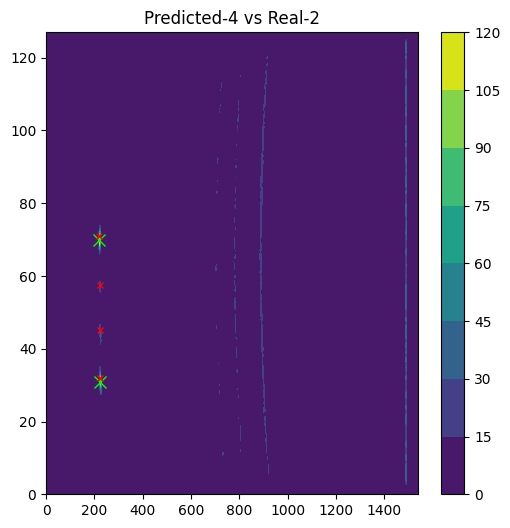

{'boxes': tensor([[ 697.6732,   45.0894,  709.1711,   54.9725],
        [ 692.0440,   76.0563,  703.8344,   86.0622],
        [ 684.2952,  106.7055,  694.5980,  116.6019],
        [ 992.3365,   84.1447, 1004.0612,   94.0878]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.9995, 0.2008, 0.0611], device='cuda:0')}
prediction=tensor([697.6732,  45.0894, 709.1711,  54.9725]) score=0.9998522996902466
Prediction coordinate x=703.4221801757812 y=50.03096008300781
prediction=tensor([692.0440,  76.0563, 703.8344,  86.0622]) score=0.999523401260376
Prediction coordinate x=697.939208984375 y=81.05925750732422
prediction=tensor([684.2952, 106.7055, 694.5980, 116.6019]) score=0.20078054070472717
----->Ignoring the prediction at x=689.4465942382812 y=111.6536636352539 with score=0.20078054070472717
prediction=tensor([ 992.3365,   84.1447, 1004.0612,   94.0878]) score=0.0611225925385952
----->Ignoring the prediction at x=998.1988525390625 y=89.11623382

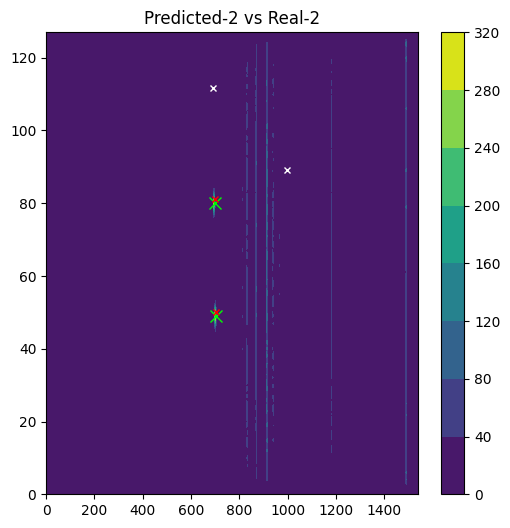

{'boxes': tensor([[7.9496e+02, 1.1189e+02, 8.0620e+02, 1.2191e+02],
        [7.8916e+02, 1.0982e-01, 7.9981e+02, 7.0654e+00]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.9990], device='cuda:0')}
prediction=tensor([794.9649, 111.8933, 806.1991, 121.9098]) score=0.9990901947021484
Prediction coordinate x=800.58203125 y=116.90153503417969
prediction=tensor([7.8916e+02, 1.0982e-01, 7.9981e+02, 7.0654e+00]) score=0.9989533424377441
Prediction coordinate x=794.4874267578125 y=3.587615966796875


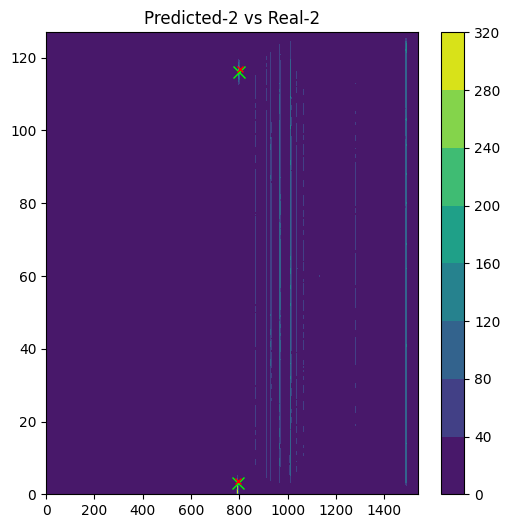

{'boxes': tensor([[439.5216, 118.0526, 446.6191, 128.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}
prediction=tensor([439.5216, 118.0526, 446.6191, 128.0000]) score=0.9956913590431213
Prediction coordinate x=443.07037353515625 y=123.02630615234375


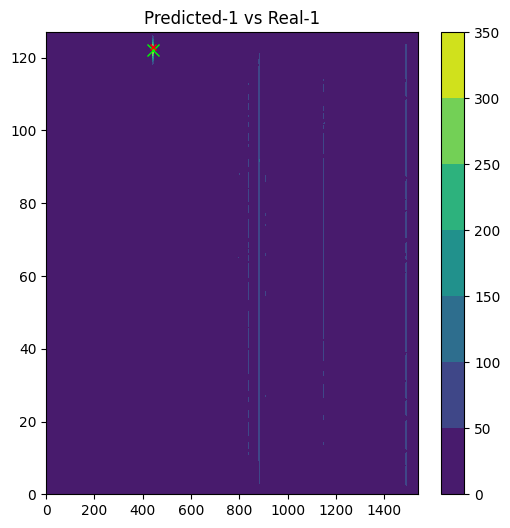

{'boxes': tensor([[550.3081,  39.9783, 557.8398,  50.0260],
        [547.6844,  14.9800, 555.1461,  25.0045],
        [550.6313,  64.0896, 558.1329,  74.0611],
        [550.1021,  87.0532, 557.6365,  96.9988]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.9988, 0.9958, 0.7435], device='cuda:0')}
prediction=tensor([550.3081,  39.9783, 557.8398,  50.0260]) score=0.9994833469390869
Prediction coordinate x=554.073974609375 y=45.002166748046875
prediction=tensor([547.6844,  14.9800, 555.1461,  25.0045]) score=0.9987527132034302
Prediction coordinate x=551.415283203125 y=19.992244720458984
prediction=tensor([550.6313,  64.0896, 558.1329,  74.0611]) score=0.9957915544509888
Prediction coordinate x=554.382080078125 y=69.0753402709961
prediction=tensor([550.1021,  87.0532, 557.6365,  96.9988]) score=0.7435495257377625
Prediction coordinate x=553.8692626953125 y=92.02603149414062


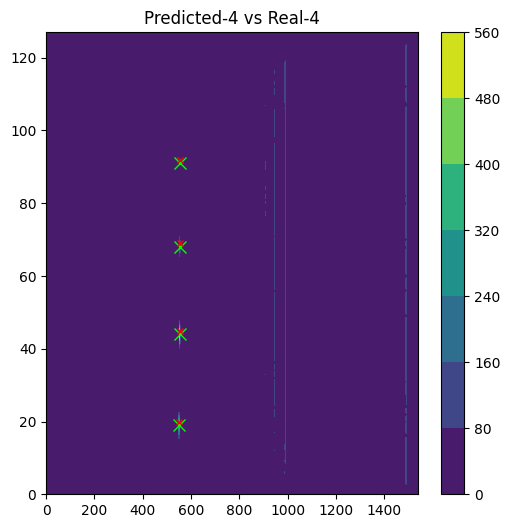

{'boxes': tensor([[484.6068,  27.0460, 492.7250,  37.0741],
        [851.7455,  27.0102, 866.9316,  36.9114],
        [274.1356,  84.1582, 278.1118,  94.0477],
        [271.4504,  42.0229, 276.0398,  52.0600],
        [854.8174,  70.2319, 870.6815,  80.1207],
        [488.6869,  91.1829, 496.4482, 101.0781],
        [486.8136,  47.9330, 494.5948,  57.9477],
        [488.2296,  69.8334, 496.0923,  79.8581],
        [273.7331,  55.2146, 278.4333,  65.2298],
        [268.3968,  27.1280, 272.8558,  36.8707],
        [273.9801,  69.7308, 278.3812,  79.9645],
        [271.8449,  98.1673, 275.9909, 108.0964]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9937, 0.9917, 0.9871, 0.9559, 0.8977, 0.8687, 0.8400, 0.8127, 0.7598,
        0.6678, 0.5969, 0.4002], device='cuda:0')}
prediction=tensor([484.6068,  27.0460, 492.7250,  37.0741]) score=0.9937154650688171
Prediction coordinate x=488.6658935546875 y=32.0600700378418
prediction=

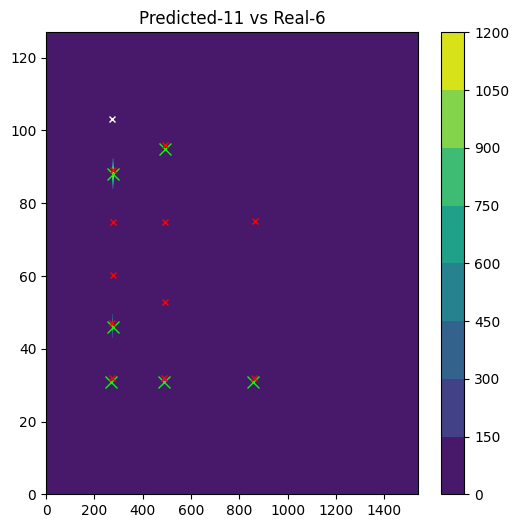

{'boxes': tensor([[424.7348,  77.9721, 437.1133,  87.9623]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}
prediction=tensor([424.7348,  77.9721, 437.1133,  87.9623]) score=0.9987762570381165
Prediction coordinate x=430.924072265625 y=82.96722412109375


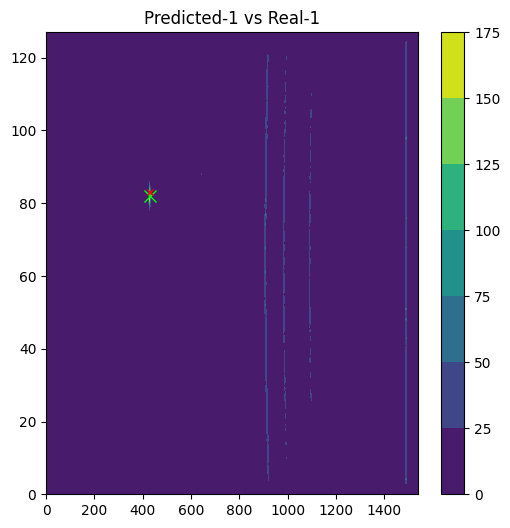

{'boxes': tensor([[409.3034,  69.8233, 416.8484,  79.8604]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9672], device='cuda:0')}
prediction=tensor([409.3034,  69.8233, 416.8484,  79.8604]) score=0.967231273651123
Prediction coordinate x=413.0758972167969 y=74.84188842773438


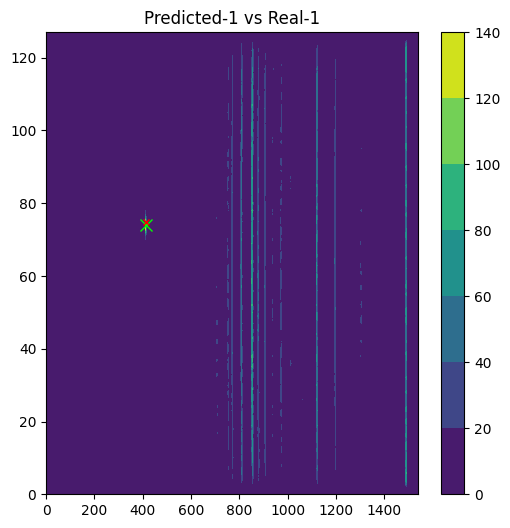

{'boxes': tensor([[226.9538,  63.0998, 232.8022,  73.1494],
        [222.2164,  49.9201, 228.3161,  60.0494],
        [229.8607,  75.8944, 236.3169,  85.9611],
        [231.1812,  89.3846, 236.9773,  99.3314]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9644, 0.9367, 0.9288, 0.4308], device='cuda:0')}
prediction=tensor([226.9538,  63.0998, 232.8022,  73.1494]) score=0.9643557667732239
Prediction coordinate x=229.87799072265625 y=68.12460327148438
prediction=tensor([222.2164,  49.9201, 228.3161,  60.0494]) score=0.9366816282272339
Prediction coordinate x=225.26625061035156 y=54.984771728515625
prediction=tensor([229.8607,  75.8944, 236.3169,  85.9611]) score=0.9288305044174194
Prediction coordinate x=233.0887908935547 y=80.92774963378906
prediction=tensor([231.1812,  89.3846, 236.9773,  99.3314]) score=0.4307633340358734
----->Ignoring the prediction at x=234.0792236328125 y=94.35798645019531 with score=0.4307633340358734


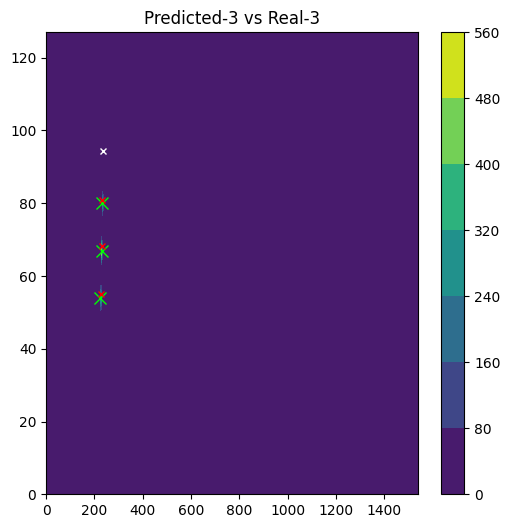

{'boxes': tensor([[656.7259,  69.0287, 678.3635,  79.0920],
        [293.3136,  84.0456, 304.2542,  94.0491],
        [287.6755,  54.9514, 299.2664,  64.6637],
        [290.8693,  68.9756, 301.9787,  79.0181],
        [287.9059,  97.9005, 298.9265, 107.8059],
        [659.3564,  98.5330, 679.5572, 108.4208]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.9663, 0.9644, 0.9398, 0.8380, 0.5297], device='cuda:0')}
prediction=tensor([656.7259,  69.0287, 678.3635,  79.0920]) score=0.9988269209861755
Prediction coordinate x=667.544677734375 y=74.06031799316406
prediction=tensor([293.3136,  84.0456, 304.2542,  94.0491]) score=0.9663475751876831
Prediction coordinate x=298.783935546875 y=89.04737091064453
prediction=tensor([287.6755,  54.9514, 299.2664,  64.6637]) score=0.9644002318382263
Prediction coordinate x=293.470947265625 y=59.807533264160156
prediction=tensor([290.8693,  68.9756, 301.9787,  79.0181]) score=0.9397920370101929
Predict

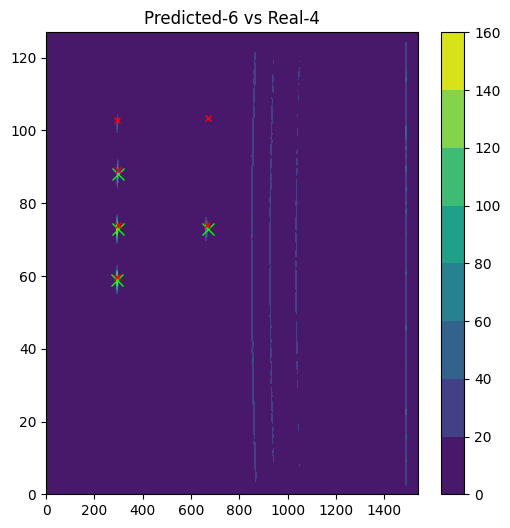

{'boxes': tensor([[609.2928,  37.0137, 615.9701,  47.1031]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}
prediction=tensor([609.2928,  37.0137, 615.9701,  47.1031]) score=0.9995206594467163
Prediction coordinate x=612.6314697265625 y=42.058372497558594


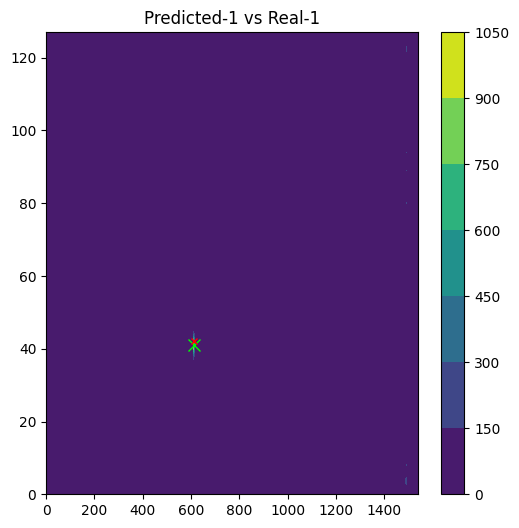

{'boxes': tensor([[ 754.5853,   81.9074,  764.3407,   91.8779],
        [ 537.9479,  105.9486,  543.7028,  115.8388],
        [1121.0883,   81.8804, 1130.6725,   91.8787],
        [ 539.9904,   82.1792,  545.8848,   92.1617],
        [ 751.6837,  119.0757,  760.8922,  128.0000],
        [ 753.0693,   47.0726,  762.6128,   57.0527],
        [ 539.8522,   59.0583,  545.6163,   68.9967],
        [ 537.0359,   35.0778,  542.9998,   44.9656]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.9995, 0.9993, 0.9985, 0.9984, 0.9971, 0.9937, 0.7737],
       device='cuda:0')}
prediction=tensor([754.5853,  81.9074, 764.3407,  91.8779]) score=0.999648928642273
Prediction coordinate x=759.4630126953125 y=86.89266967773438
prediction=tensor([537.9479, 105.9486, 543.7028, 115.8388]) score=0.9995136260986328
Prediction coordinate x=540.8253784179688 y=110.89368438720703
prediction=tensor([1121.0883,   81.8804, 1130.6725,   91.8787]) score=0.9993

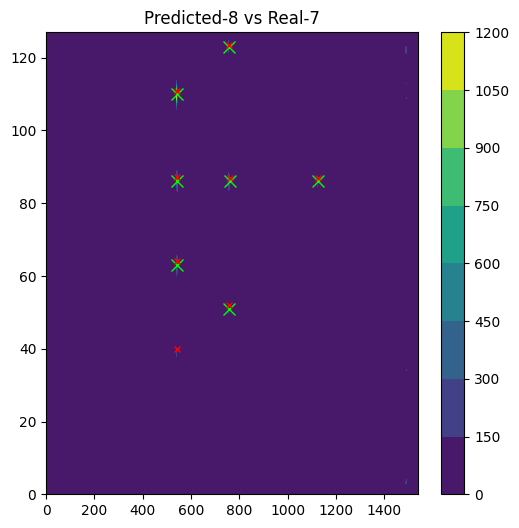

{'boxes': tensor([[602.7421,  40.0105, 613.8217,  49.9860],
        [602.6841,  93.0220, 613.1513, 103.0119],
        [386.5529,  30.9966, 392.1629,  40.9894],
        [386.8015, 102.0752, 392.2211, 112.0570],
        [387.9145,  48.7711, 393.5486,  58.8149],
        [389.0704,  66.9005, 394.6669,  76.9643],
        [387.8253,  85.1878, 393.4069,  95.1688]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.9973, 0.9869, 0.9740, 0.7699, 0.7311, 0.5858],
       device='cuda:0')}
prediction=tensor([602.7421,  40.0105, 613.8217,  49.9860]) score=0.9995889067649841
Prediction coordinate x=608.2818603515625 y=44.998260498046875
prediction=tensor([602.6841,  93.0220, 613.1513, 103.0119]) score=0.9973133206367493
Prediction coordinate x=607.917724609375 y=98.0169677734375
prediction=tensor([386.5529,  30.9966, 392.1629,  40.9894]) score=0.9869099259376526
Prediction coordinate x=389.35791015625 y=35.993019104003906
prediction=tensor([386.8

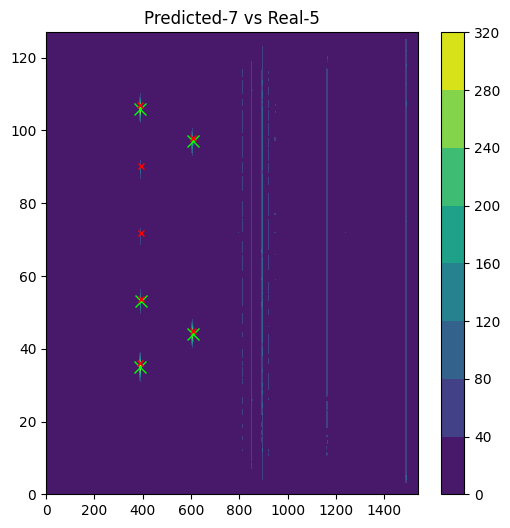

{'boxes': tensor([[5.4426e+02, 1.9214e-02, 5.5159e+02, 6.0200e+00],
        [7.5901e+02, 0.0000e+00, 7.6877e+02, 6.0397e+00],
        [1.1267e+03, 0.0000e+00, 1.1368e+03, 1.5223e+00],
        [1.1355e+03, 2.6367e+00, 1.1442e+03, 1.2029e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.9907, 0.5940, 0.1018], device='cuda:0')}
prediction=tensor([5.4426e+02, 1.9214e-02, 5.5159e+02, 6.0200e+00]) score=0.9991700649261475
Prediction coordinate x=547.924560546875 y=3.0196049213409424
prediction=tensor([759.0134,   0.0000, 768.7747,   6.0397]) score=0.9906561970710754
Prediction coordinate x=763.89404296875 y=3.0198304653167725
prediction=tensor([1126.7253,    0.0000, 1136.7677,    1.5223]) score=0.5939621329307556
Prediction coordinate x=1131.74658203125 y=0.7611427903175354
prediction=tensor([1135.4902,    2.6367, 1144.2233,   12.0289]) score=0.10180377215147018
----->Ignoring the prediction at x=1139.856689453125 y=7.332830429077148 with s

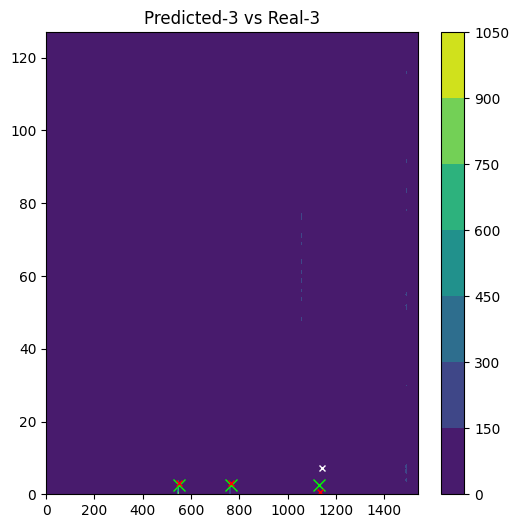

{'boxes': tensor([[505.1513,  95.1427, 532.6846, 105.0727]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9713], device='cuda:0')}
prediction=tensor([505.1513,  95.1427, 532.6846, 105.0727]) score=0.9713472127914429
Prediction coordinate x=518.91796875 y=100.10768127441406


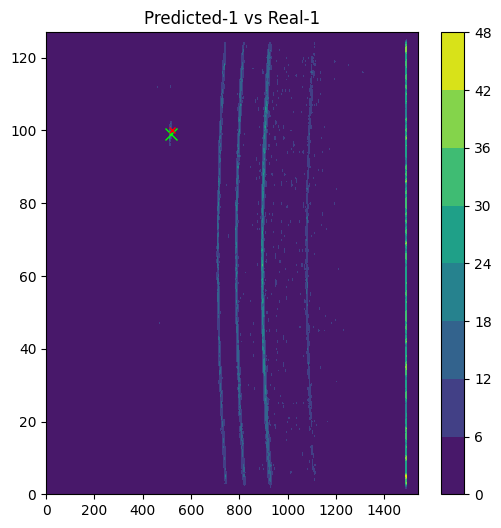

{'boxes': tensor([[388.5737,   5.0332, 400.6404,  14.9977]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}
prediction=tensor([388.5737,   5.0332, 400.6404,  14.9977]) score=0.9967271089553833
Prediction coordinate x=394.6070556640625 y=10.01545524597168


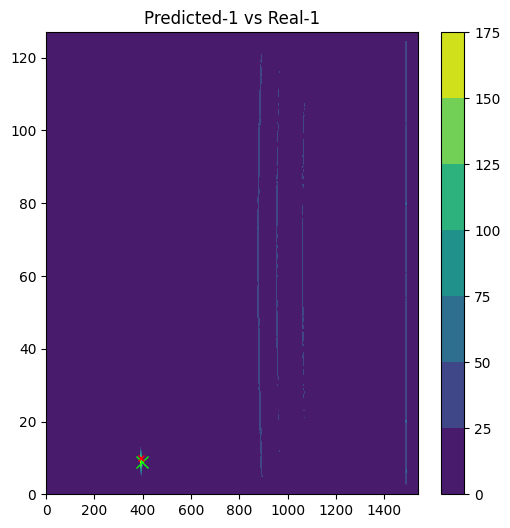

{'boxes': tensor([[259.4525,  48.9600, 300.0708,  58.9305],
        [258.5276,  63.3932, 303.3982,  72.8813]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.4945], device='cuda:0')}
prediction=tensor([259.4525,  48.9600, 300.0708,  58.9305]) score=0.9977959394454956
Prediction coordinate x=279.7616271972656 y=53.94526672363281
prediction=tensor([258.5276,  63.3932, 303.3982,  72.8813]) score=0.49448204040527344
----->Ignoring the prediction at x=280.962890625 y=68.13725280761719 with score=0.49448204040527344


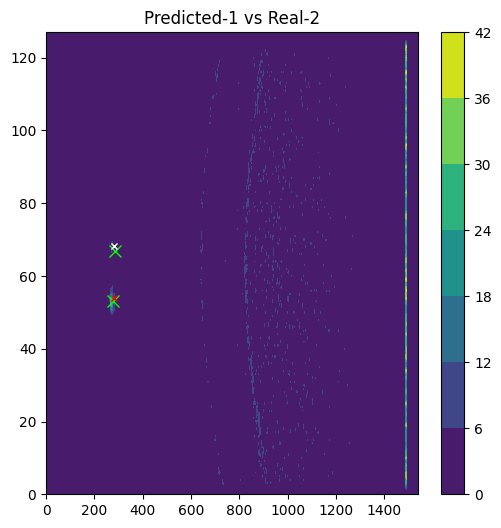

{'boxes': tensor([[774.3530,  82.0338, 784.2591,  92.0057],
        [561.9959,  71.0440, 568.2492,  81.0325],
        [556.2806,  94.9152, 562.2446, 104.9278]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9996, 0.8214], device='cuda:0')}
prediction=tensor([774.3530,  82.0338, 784.2591,  92.0057]) score=0.999674916267395
Prediction coordinate x=779.3060302734375 y=87.019775390625
prediction=tensor([561.9959,  71.0440, 568.2492,  81.0325]) score=0.999560534954071
Prediction coordinate x=565.12255859375 y=76.03823852539062
prediction=tensor([556.2806,  94.9152, 562.2446, 104.9278]) score=0.8213744759559631
Prediction coordinate x=559.2625732421875 y=99.92147827148438


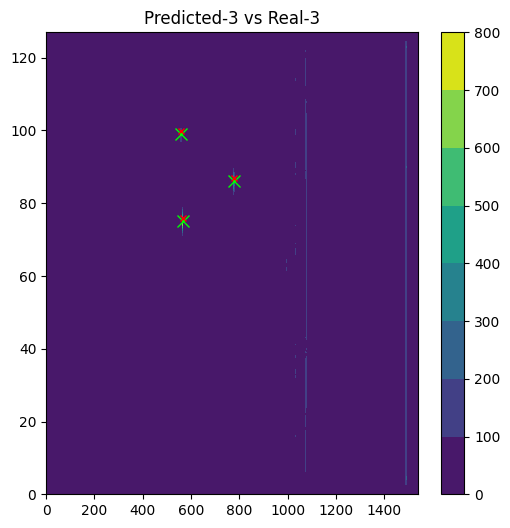

{'boxes': tensor([[398.5859,  70.9198, 411.7314,  80.8464],
        [400.8729,  52.8967, 414.6844,  63.0197]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9929, 0.9881], device='cuda:0')}
prediction=tensor([398.5859,  70.9198, 411.7314,  80.8464]) score=0.9928572177886963
Prediction coordinate x=405.15863037109375 y=75.88307189941406
prediction=tensor([400.8729,  52.8967, 414.6844,  63.0197]) score=0.9880770444869995
Prediction coordinate x=407.77862548828125 y=57.95817947387695


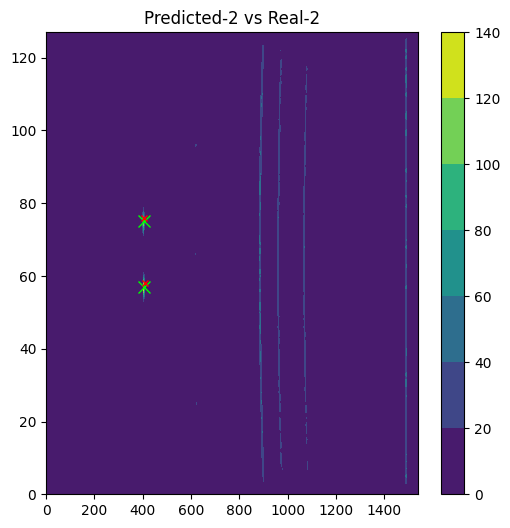

{'boxes': tensor([[643.1655,  42.1076, 650.7120,  52.1009],
        [641.7197,  13.1840, 648.7430,  23.0696],
        [642.7083,  71.0158, 649.8701,  81.0181]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.9972, 0.7159], device='cuda:0')}
prediction=tensor([643.1655,  42.1076, 650.7120,  52.1009]) score=0.9999282360076904
Prediction coordinate x=646.938720703125 y=47.104270935058594
prediction=tensor([641.7197,  13.1840, 648.7430,  23.0696]) score=0.9972456693649292
Prediction coordinate x=645.2313232421875 y=18.126811981201172
prediction=tensor([642.7083,  71.0158, 649.8701,  81.0181]) score=0.7159155011177063
Prediction coordinate x=646.2891845703125 y=76.01693725585938


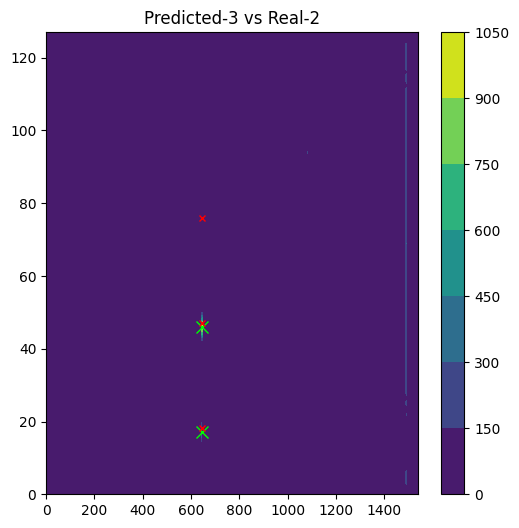

{'boxes': tensor([[632.0717,  53.0245, 645.1191,  62.8830],
        [623.7375,  80.0371, 637.0328,  90.0247],
        [636.6918,  25.0655, 649.5912,  35.0799]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.9980, 0.9906], device='cuda:0')}
prediction=tensor([632.0717,  53.0245, 645.1191,  62.8830]) score=0.999876856803894
Prediction coordinate x=638.5953979492188 y=57.953739166259766
prediction=tensor([623.7375,  80.0371, 637.0328,  90.0247]) score=0.9979550838470459
Prediction coordinate x=630.3851318359375 y=85.0308837890625
prediction=tensor([636.6918,  25.0655, 649.5912,  35.0799]) score=0.9905692338943481
Prediction coordinate x=643.1415405273438 y=30.07268714904785


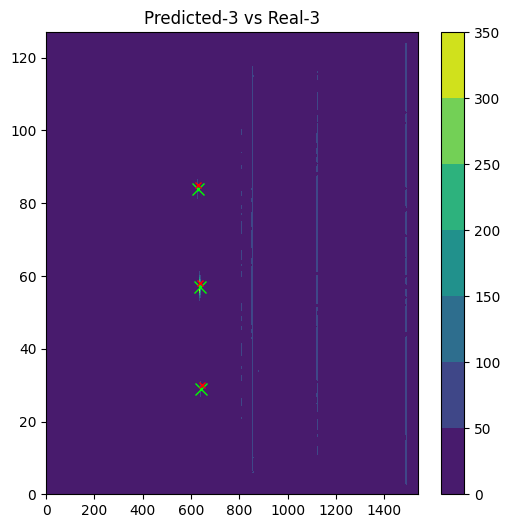

{'boxes': tensor([[439.0415,  88.9517, 451.0359,  99.0318],
        [443.6196,   8.9145, 454.9078,  18.7407]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8963, 0.8455], device='cuda:0')}
prediction=tensor([439.0415,  88.9517, 451.0359,  99.0318]) score=0.8963033556938171
Prediction coordinate x=445.0386962890625 y=93.99174499511719
prediction=tensor([443.6196,   8.9145, 454.9078,  18.7407]) score=0.8455328941345215
Prediction coordinate x=449.263671875 y=13.82759952545166


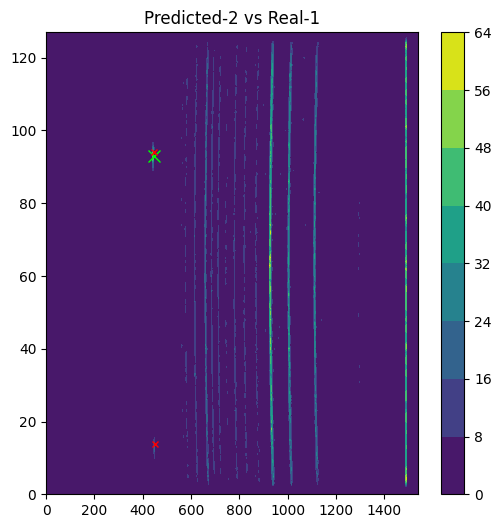

{'boxes': tensor([[ 698.2141,  103.0064,  708.2746,  113.0010],
        [ 483.3336,  103.0759,  489.1620,  113.1865],
        [1064.7091,  103.1542, 1075.9435,  113.0757]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.9940, 0.8577], device='cuda:0')}
prediction=tensor([698.2141, 103.0064, 708.2746, 113.0010]) score=0.9994304776191711
Prediction coordinate x=703.2443237304688 y=108.00372314453125
prediction=tensor([483.3336, 103.0759, 489.1620, 113.1865]) score=0.9940270185470581
Prediction coordinate x=486.2478332519531 y=108.1312255859375
prediction=tensor([1064.7091,  103.1542, 1075.9435,  113.0757]) score=0.8576685190200806
Prediction coordinate x=1070.3262939453125 y=108.11492156982422


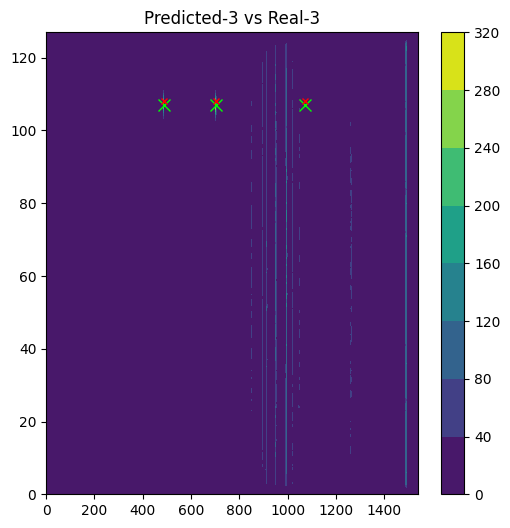

{'boxes': tensor([[376.8181,  22.0374, 385.1854,  32.0510],
        [752.5191,  74.8733, 770.2856,  84.8566],
        [386.3339,  91.9956, 395.7465, 102.0185],
        [385.0654,  75.1830, 394.3020,  85.1212],
        [754.8414,  37.4930, 772.0523,  47.4243]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.8719, 0.8523, 0.6022, 0.2657], device='cuda:0')}
prediction=tensor([376.8181,  22.0374, 385.1854,  32.0510]) score=0.999177873134613
Prediction coordinate x=381.00177001953125 y=27.044187545776367
prediction=tensor([752.5191,  74.8733, 770.2856,  84.8566]) score=0.8719051480293274
Prediction coordinate x=761.40234375 y=79.86492919921875
prediction=tensor([386.3339,  91.9956, 395.7465, 102.0185]) score=0.852340042591095
Prediction coordinate x=391.0401916503906 y=97.0070571899414
prediction=tensor([385.0654,  75.1830, 394.3020,  85.1212]) score=0.6021537780761719
Prediction coordinate x=389.6837158203125 y=80.15209197998047
prediction

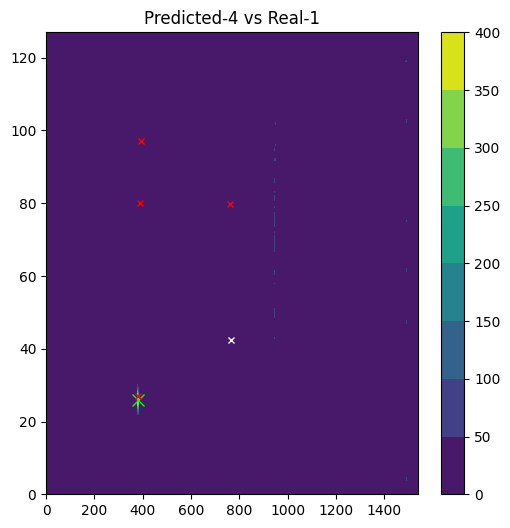

{'boxes': tensor([[489.1986,  34.0070, 495.3816,  43.9892],
        [484.8825,  11.9663, 491.1945,  21.9458]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9748], device='cuda:0')}
prediction=tensor([489.1986,  34.0070, 495.3816,  43.9892]) score=0.9997329115867615
Prediction coordinate x=492.29010009765625 y=38.99810028076172
prediction=tensor([484.8825,  11.9663, 491.1945,  21.9458]) score=0.9748493432998657
Prediction coordinate x=488.0384826660156 y=16.956043243408203


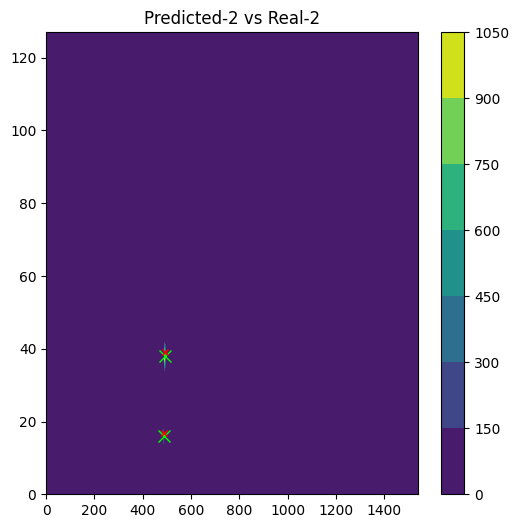

{'boxes': tensor([[420.7029,  84.0743, 427.7507,  94.1155],
        [411.7491,  46.8979, 418.7180,  56.6756],
        [422.6562, 103.0701, 429.6261, 112.9250],
        [416.0880,  65.2022, 422.9232,  75.0547]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.9349, 0.9135, 0.8696], device='cuda:0')}
prediction=tensor([420.7029,  84.0743, 427.7507,  94.1155]) score=0.9999061822891235
Prediction coordinate x=424.226806640625 y=89.09487915039062
prediction=tensor([411.7491,  46.8979, 418.7180,  56.6756]) score=0.9348732233047485
Prediction coordinate x=415.2335205078125 y=51.78670883178711
prediction=tensor([422.6562, 103.0701, 429.6261, 112.9250]) score=0.9135276079177856
Prediction coordinate x=426.14117431640625 y=107.99756622314453
prediction=tensor([416.0880,  65.2022, 422.9232,  75.0547]) score=0.8696310520172119
Prediction coordinate x=419.505615234375 y=70.1284408569336


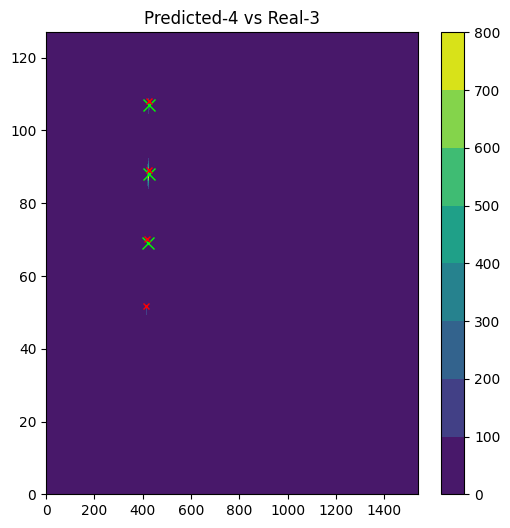

{'boxes': tensor([[642.7986,  34.9162, 650.1937,  44.8410],
        [638.5944,   5.8857, 645.6961,  15.9395],
        [643.6711,  62.5563, 651.0762,  72.5351]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.5376, 0.3489], device='cuda:0')}
prediction=tensor([642.7986,  34.9162, 650.1937,  44.8410]) score=0.9997598528862
Prediction coordinate x=646.4961547851562 y=39.878578186035156
prediction=tensor([638.5944,   5.8857, 645.6961,  15.9395]) score=0.5376380085945129
Prediction coordinate x=642.145263671875 y=10.91259479522705
prediction=tensor([643.6711,  62.5563, 651.0762,  72.5351]) score=0.3489285409450531
----->Ignoring the prediction at x=647.3736572265625 y=67.54568481445312 with score=0.3489285409450531


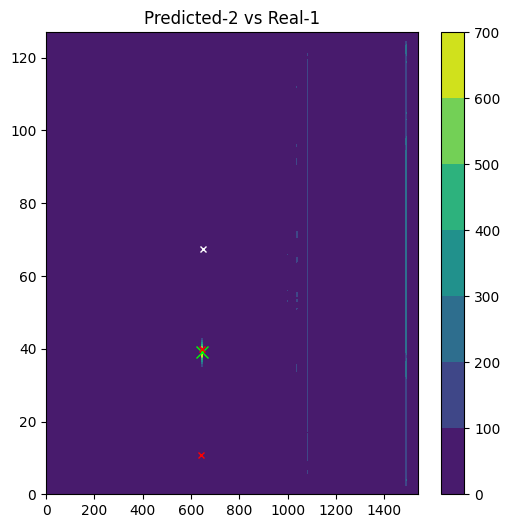

{'boxes': tensor([[467.4753,  50.8419, 474.7043,  60.8891]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8572], device='cuda:0')}
prediction=tensor([467.4753,  50.8419, 474.7043,  60.8891]) score=0.8572419285774231
Prediction coordinate x=471.08984375 y=55.865501403808594


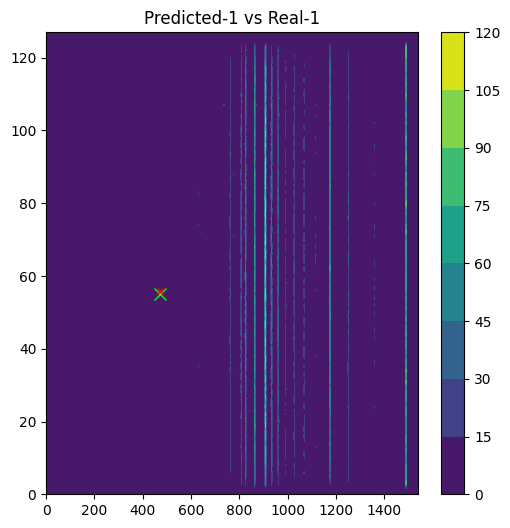

{'boxes': tensor([[243.3719,  11.8977, 248.5471,  21.8508],
        [278.8611, 123.0980, 284.6698, 127.9691]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.7877], device='cuda:0')}
prediction=tensor([243.3719,  11.8977, 248.5471,  21.8508]) score=0.999026894569397
Prediction coordinate x=245.95947265625 y=16.874225616455078
prediction=tensor([278.8611, 123.0980, 284.6698, 127.9691]) score=0.7876970171928406
Prediction coordinate x=281.7654113769531 y=125.5335693359375


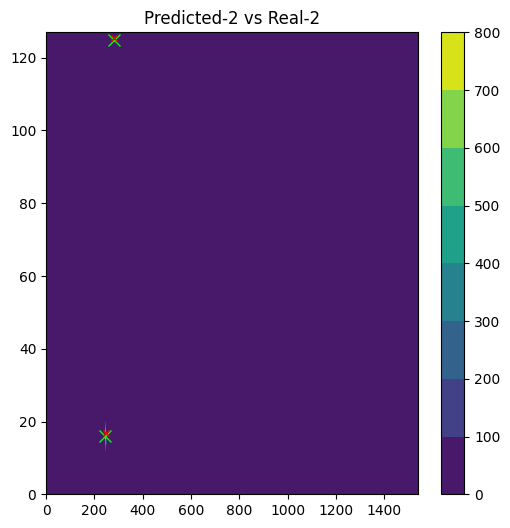

{'boxes': tensor([[554.7122, 122.1011, 565.7529, 128.0000],
        [572.7948,  48.0073, 584.2916,  57.9684],
        [922.3654, 121.3826, 933.3124, 128.0000],
        [340.3111, 121.8027, 345.5372, 128.0000],
        [356.8700,  57.0718, 362.8248,  67.0641],
        [358.2114,  40.1229, 364.2356,  50.1165]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.9984, 0.9081, 0.8760, 0.7390, 0.6120], device='cuda:0')}
prediction=tensor([554.7122, 122.1011, 565.7529, 128.0000]) score=0.9989026784896851
Prediction coordinate x=560.2325439453125 y=125.05056762695312
prediction=tensor([572.7948,  48.0073, 584.2916,  57.9684]) score=0.9984367489814758
Prediction coordinate x=578.543212890625 y=52.98785400390625
prediction=tensor([922.3654, 121.3826, 933.3124, 128.0000]) score=0.9080783724784851
Prediction coordinate x=927.8389282226562 y=124.6912841796875
prediction=tensor([340.3111, 121.8027, 345.5372, 128.0000]) score=0.8760270476341248
Predi

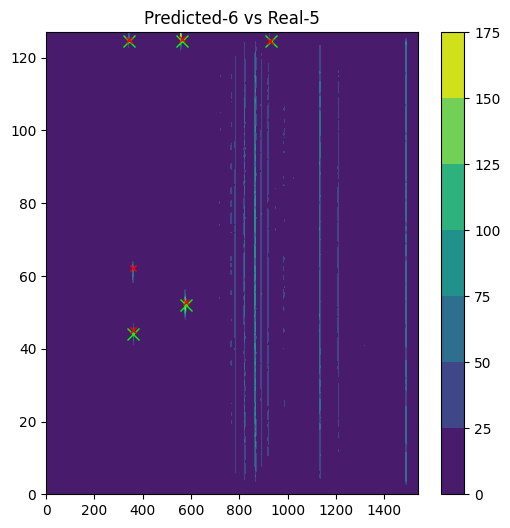

{'boxes': tensor([[589.3840,  93.9388, 596.4393, 103.9727]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}
prediction=tensor([589.3840,  93.9388, 596.4393, 103.9727]) score=0.9997879862785339
Prediction coordinate x=592.91162109375 y=98.95576477050781


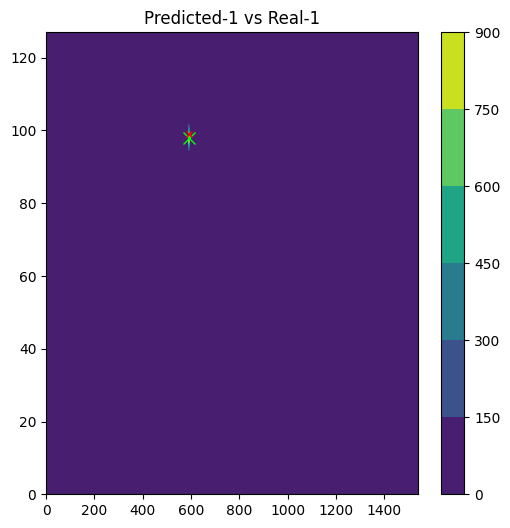

{'boxes': tensor([[241.6813, 120.0863, 247.1367, 128.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9877], device='cuda:0')}
prediction=tensor([241.6813, 120.0863, 247.1367, 128.0000]) score=0.9876870512962341
Prediction coordinate x=244.40896606445312 y=124.04316711425781


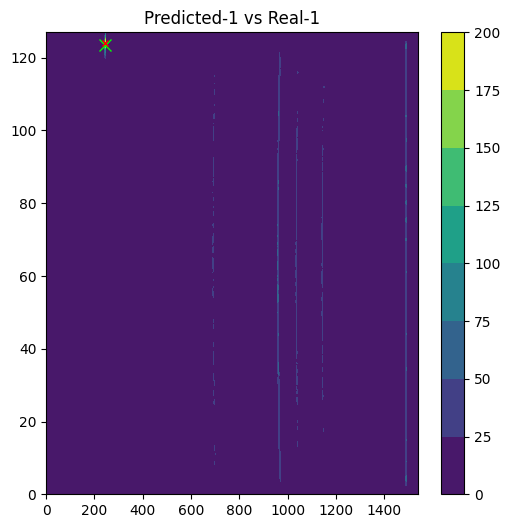

{'boxes': tensor([[501.5244,  23.2257, 508.4454,  33.1541]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9746], device='cuda:0')}
prediction=tensor([501.5244,  23.2257, 508.4454,  33.1541]) score=0.9745720028877258
Prediction coordinate x=504.98492431640625 y=28.18990707397461


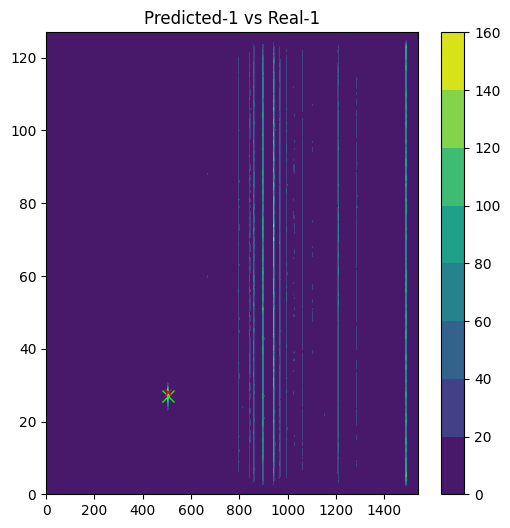

{'boxes': tensor([[345.8269,  34.9838, 351.7089,  44.9701],
        [562.0379,  27.0392, 572.5376,  36.9497],
        [342.7782,  51.2300, 348.3154,  61.2225]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9894, 0.9411, 0.2648], device='cuda:0')}
prediction=tensor([345.8269,  34.9838, 351.7089,  44.9701]) score=0.9894202947616577
Prediction coordinate x=348.76788330078125 y=39.97694396972656
prediction=tensor([562.0379,  27.0392, 572.5376,  36.9497]) score=0.9410645365715027
Prediction coordinate x=567.2877197265625 y=31.99443817138672
prediction=tensor([342.7782,  51.2300, 348.3154,  61.2225]) score=0.26476067304611206
----->Ignoring the prediction at x=345.54681396484375 y=56.226253509521484 with score=0.26476067304611206


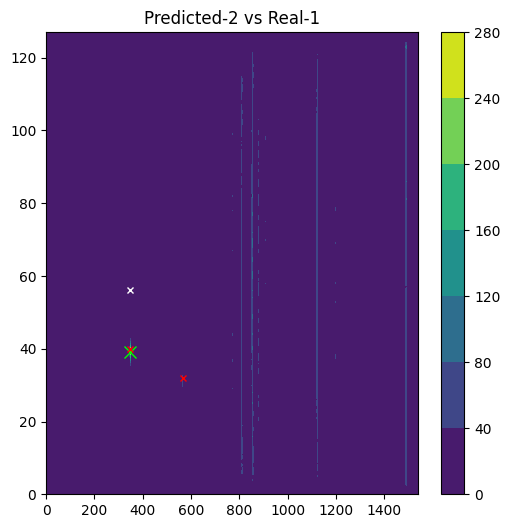

{'boxes': tensor([[408.4279,  50.0877, 416.0421,  60.0081],
        [406.8350,  68.0886, 414.2739,  78.0608],
        [394.2896, 122.8100, 401.3645, 128.0000],
        [404.4454,  87.3092, 411.3460,  97.3028]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9881, 0.8985, 0.8670, 0.0688], device='cuda:0')}
prediction=tensor([408.4279,  50.0877, 416.0421,  60.0081]) score=0.9881373047828674
Prediction coordinate x=412.2349853515625 y=55.04791259765625
prediction=tensor([406.8350,  68.0886, 414.2739,  78.0608]) score=0.8984860181808472
Prediction coordinate x=410.554443359375 y=73.07470703125
prediction=tensor([394.2896, 122.8100, 401.3645, 128.0000]) score=0.8670409917831421
Prediction coordinate x=397.8270263671875 y=125.40498352050781
prediction=tensor([404.4454,  87.3092, 411.3460,  97.3028]) score=0.06880944222211838
----->Ignoring the prediction at x=407.89569091796875 y=92.30598449707031 with score=0.06880944222211838


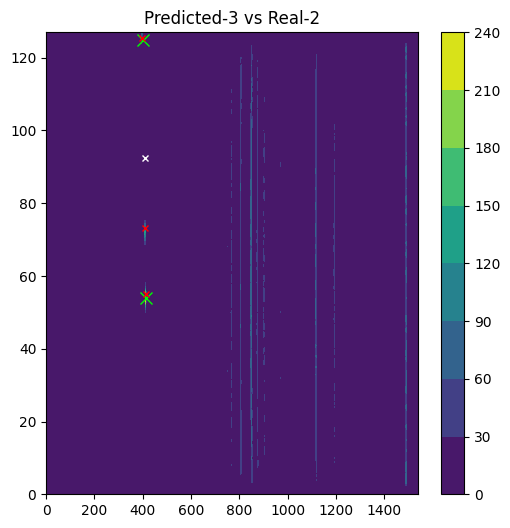

{'boxes': tensor([[321.6062,   7.0450, 326.6092,  16.8892]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}
prediction=tensor([321.6062,   7.0450, 326.6092,  16.8892]) score=0.9943689703941345
Prediction coordinate x=324.1076965332031 y=11.967131614685059


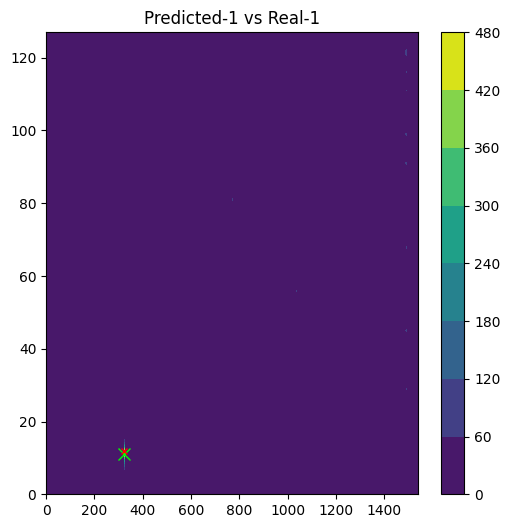

{'boxes': tensor([[574.1379,   6.9296, 580.9490,  17.0019],
        [575.9021,  32.0298, 582.9122,  41.9880]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9918, 0.7202], device='cuda:0')}
prediction=tensor([574.1379,   6.9296, 580.9490,  17.0019]) score=0.9918437600135803
Prediction coordinate x=577.54345703125 y=11.965733528137207
prediction=tensor([575.9021,  32.0298, 582.9122,  41.9880]) score=0.7202373147010803
Prediction coordinate x=579.4071044921875 y=37.0088996887207


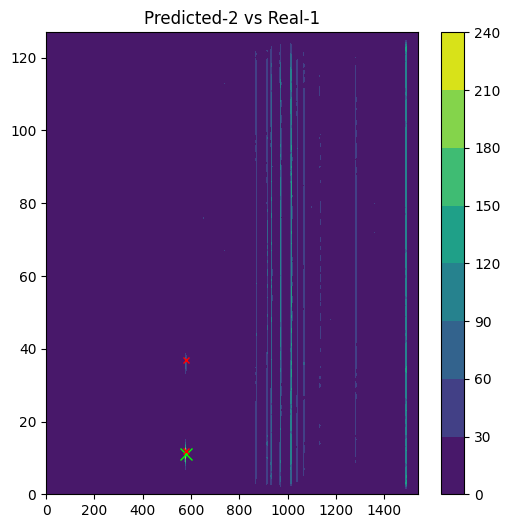

{'boxes': tensor([[231.4377,  90.9569, 237.2900, 100.9578],
        [232.6682,   0.0000, 239.0338,   7.9487]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.9747], device='cuda:0')}
prediction=tensor([231.4377,  90.9569, 237.2900, 100.9578]) score=0.9976968169212341
Prediction coordinate x=234.36386108398438 y=95.95735931396484
prediction=tensor([232.6682,   0.0000, 239.0338,   7.9487]) score=0.974736750125885
Prediction coordinate x=235.85101318359375 y=3.97432541847229


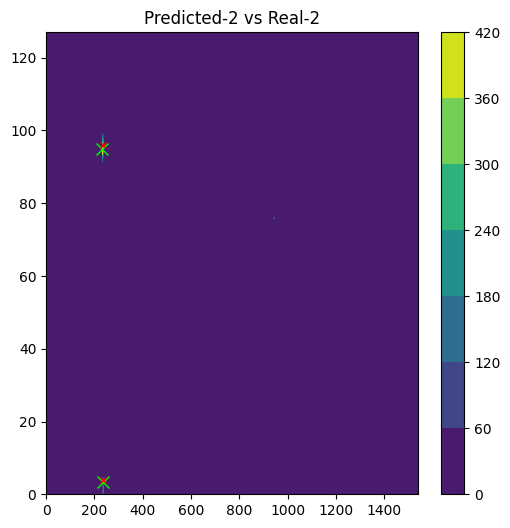

In [41]:
r_model.eval()
probe = 0
for img, target in data_loader_test:
    imgs = list(img)
    targets = list(target)
    with tc.no_grad():
        for img, target in zip(imgs, targets):
            prediction = r_model([img.to(device)])[0]
            nms_prediction = apply_nms(prediction, iou_thresh=0.001)
            print(nms_prediction)
            plot_frame_detections(img[0,:,:], target['boxes'], nms_prediction, score_threshold = 0.5)
            probe += 1

    if probe >= 50:
        break